In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-01 17:58:22 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-01 17:58:22 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-01 17:58:22 __main__ INFO     transformers.__version__='4.54.1'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-01 17:58:25 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-01 17:58:25 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-01 17:58:25 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-01 17:58:25 wandb.docker.auth DEBUG    No config file found


In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-01 17:58:26 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-01 17:58:26 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-01 17:58:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-08-01 17:58:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-01 17:58:26 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/meta-llama/Llama-3.3-70B-Instruct/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

2025-08-01 17:59:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-01 17:59:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-01 17:59:14 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "64"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001",
    model_key.split("/")[-1],
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas["model<>layers<>5<>mlp<>gate_proj"]
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-08-01 17:59:21 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-08-01 17:59:22 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-08-01 17:59:22 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-08-01 17:59:22 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-08-01 17:59:22 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-08-01 17:59:22 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-08-01 17:59:22 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
202

In [8]:
from src.selection.data  import load_people_by_category, get_random_sample

people_by_category = load_people_by_category(tokenizer = mt.tokenizer)
list(people_by_category.keys())

2025-08-01 17:49:50 src.selection.data INFO     Loaded 16 categories


['actor',
 'singer',
 'comedian',
 'director',
 'basketball player',
 'football player',
 'soccer player',
 'tennis player',
 'golfer',
 'boxer',
 'news anchor',
 'journalist',
 'author',
 'fashion designer',
 'entrepreneur',
 'politician']

In [9]:
from scripts.locate_resolution_heads import SelectionSampleAttn

attn_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection/attention_patterns",
    mt.name.split("/")[-1]
)
files = sorted(os.listdir(attn_path))

#######################################################################
LIMIT = 40
# LIMIT = len(files)
#######################################################################

selection_attns = []

for npz_file in files[:LIMIT]:
    if not npz_file.endswith(".npz"):
        continue

    npz_path = os.path.join(attn_path, npz_file)
    selection_attns.append(SelectionSampleAttn.from_npz(npz_path))
    if len(selection_attns) % 10 == 0:
        print(f"Loaded {len(selection_attns)}/{LIMIT} files")

Loaded 10/40 files
Loaded 20/40 files
Loaded 30/40 files
Loaded 40/40 files


In [10]:
len(selection_attns)

40

In [11]:
from src.attention import visualize_attn_matrix

sample_idx = 18
# layer_idx = 39
# head_idx = 40
layer_idx = 54
head_idx = 44

selection_attn = selection_attns[sample_idx]
print(selection_attn.resolution_score(layer_idx, head_idx))
visualize_attn_matrix(
    attn_matrix=selection_attn.attention_pattern.attention_matrices[layer_idx, head_idx],
    tokens=selection_attn.attention_pattern.tokenized_prompt,
    q_index=-1,
    start_from=1,
)

(-2.1696090698242188e-05, 9.489059448242188e-05, [0.00011658668518066406, 6.937980651855469e-05, 0.00010991096496582031, 0.00010371208190917969, 9.202957153320312e-05])


In [12]:
from tqdm.auto import tqdm

#############################################################################
n_layer = mt.n_layer
n_head = mt.config.num_attention_heads
# token_idx = "all"
token_idx = "last"
##############################################################################

resolution_scores = torch.zeros((n_head, n_layer), dtype=torch.float32)
for selection_attn in tqdm(selection_attns):
    for layer_idx in range(n_layer):
        for head_idx in range(n_head):
            resolution_scores[head_idx, layer_idx] += selection_attn.resolution_score(
                layer_idx, head_idx, token_idx=token_idx
            )[0]
            # resolution_scores[head_idx, layer_idx] += selection_attn.first_token_score(
            #     layer_idx, head_idx
            # )[0]

resolution_scores /= len(selection_attns)
resolution_scores.shape

  0%|          | 0/40 [00:00<?, ?it/s]

torch.Size([64, 80])

In [13]:
resolution_scores[19, 35]

tensor(0.2386)

2025-08-01 17:50:50 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-01 17:50:50 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-01 17:50:50 matplotlib DEBUG    interactive is False
2025-08-01 17:50:50 matplotlib DEBUG    platform is linux
2025-08-01 17:50:50 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-01 17:50:50 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-01 17:50:51 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-01 17:50:51 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-01 17:50:51 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-01 17:50:51 matplotlib.font

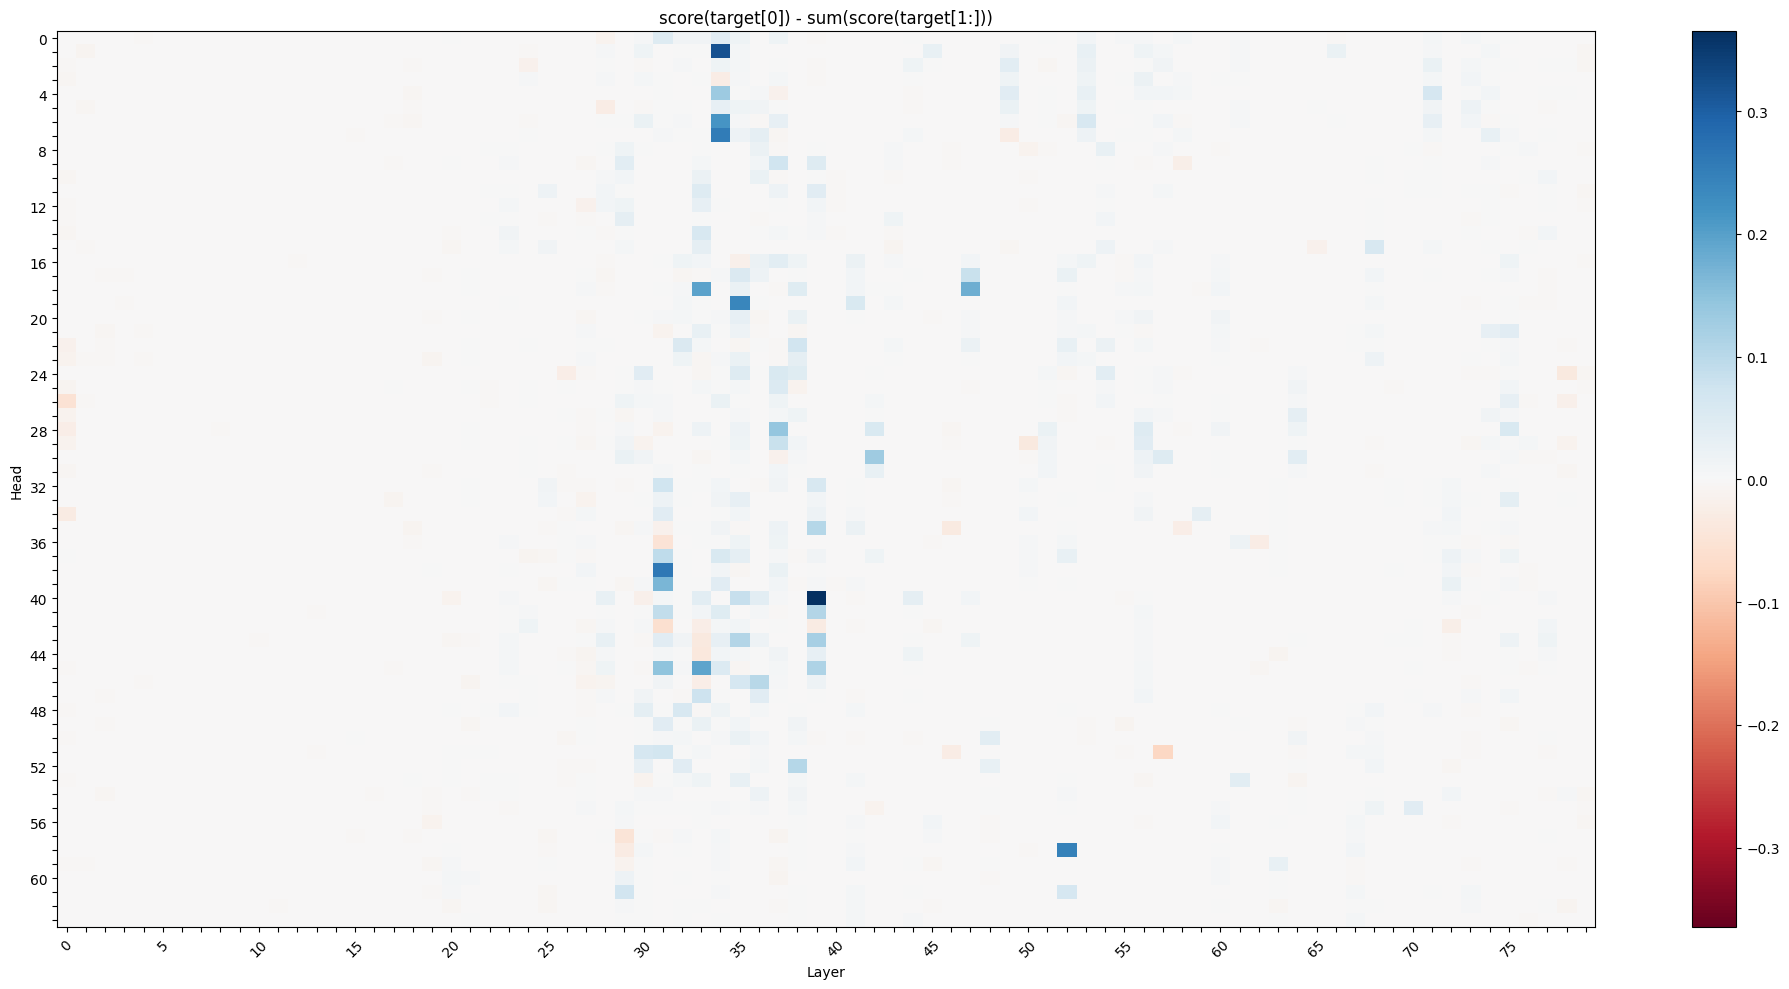

Layer 39, Head 40: 0.3650
Layer 34, Head 1: 0.3181
Layer 31, Head 38: 0.2621
Layer 34, Head 7: 0.2559
Layer 52, Head 58: 0.2455
Layer 35, Head 19: 0.2386
Layer 34, Head 6: 0.2140
Layer 33, Head 18: 0.1955
Layer 33, Head 45: 0.1922
Layer 47, Head 18: 0.1786
Layer 31, Head 39: 0.1675
Layer 31, Head 45: 0.1468
Layer 37, Head 28: 0.1421
Layer 34, Head 4: 0.1336
Layer 42, Head 30: 0.1299


In [14]:
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 10))
scale = torch.max(torch.abs(resolution_scores))
plt.imshow(
    resolution_scores.cpu().numpy(),
    cmap="RdBu",
    aspect="auto",
    vmin=-scale,
    vmax=scale,
)
plt.colorbar()
# plt.title(f"score(target) - max(score(distractors)) | {token_idx.upper()} tokens of options")
plt.title("score(target[0]) - sum(score(target[1:]))")
plt.xlabel("Layer")
plt.ylabel("Head")

def get_ticks(ticks, skip=5):
    ret = []
    for i in ticks:
        if i % skip == 0:
            ret.append(str(i))
        else:
            ret.append("")
    return ret

plt.xticks(
    ticks=range(n_layer),
    labels=get_ticks(range(n_layer)),
    rotation=45,
)
plt.yticks(
    ticks=range(n_head),
    labels=get_ticks(range(n_head), skip=4),
)

plt.tight_layout()
plt.show()


scores_per_head = []
for head_idx in range(n_head):
    for layer_idx in range(n_layer):
        scores_per_head.append(
            (head_idx, layer_idx, resolution_scores[head_idx, layer_idx].item())
        )

scores_per_head = sorted(scores_per_head, key=lambda x: x[2], reverse=True)
for head_idx, layer_idx, score in scores_per_head[:15]:
    print(f"Layer {layer_idx}, Head {head_idx}: {score:.4f}")

In [ ]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id
from src.selection.data import SelectionSample
from src.functional import predict_next_token

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


def get_counterfactual_samples_on_pivot_entity(
    patch_category=None, clean_category=None
):
    if patch_category is None:
        patch_category = random.choice(list(people_by_category.keys()))

    patch_subj, patch_obj = random.sample(people_by_category[patch_category].values, 2)
    logger.info(
        f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    )

    if clean_category is None:
        clean_category = random.choice(
            list(set(people_by_category.keys()) - {patch_category})
        )
    clean_subj, clean_obj = random.sample(people_by_category[clean_category].values, 2)
    logger.info(
        f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    )

    distractors = []
    other_categories = random.sample(
        list(set(people_by_category.keys()) - {patch_category, clean_category}),
        k=N_DISTRACTORS - 1,
    )

    for other_category in other_categories:
        distractors.append(
            random.choice(
                (
                    people_by_category[other_category]
                    - KeyedSet(
                        [patch_obj, clean_obj] + distractors, tokenizer=mt.tokenizer
                    )
                ).values
            )
        )

    patch_options = [patch_obj, clean_obj] + distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    logger.info(f"{patch_obj_idx=} | {patch_options}")

    clean_options = copy.deepcopy(patch_options)
    while (
        clean_options.index(clean_obj) == patch_obj_idx
        or clean_options.index(patch_obj) == patch_obj_idx
    ):
        random.shuffle(clean_options)

    clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        obj_idx=patch_obj_idx,
        obj_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        metadata={"attribute": patch_category},
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        obj_idx=clean_obj_idx,
        obj_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        metadata={
            "attribute": clean_category,
        },
    )

    for sample in [patch_sample, clean_sample]:
        pred = predict_next_token(
            mt=mt,
            inputs=sample.prompt,
        )[0]
        logger.info(f"{sample.subj} -> {sample.obj} | pred={[str(p) for p in pred]}")
        if pred[0].token_id != sample.obj_token_id:
            logger.error(
                f'Prediction mismatch: {pred[0].token_id}["{mt.tokenizer.decode(pred[0].token_id)}"] != {sample.obj_token_id}["{mt.tokenizer.decode(sample.obj_token_id)}"]'
            )
            return get_counterfactual_samples_on_pivot_entity()
        sample.prediction = pred

    return patch_sample, clean_sample

In [30]:
from src.selection.data import SelectionSample, get_random_sample

patch_sample, clean_sample = get_counterfactual_samples_on_pivot_entity(
    patch_category="politician",
    clean_category="actor"
)

print(patch_sample.prompt, " >> ", f'"{patch_sample.obj}"')
print(f"{[str(p) for p in patch_sample.prediction]}")
print(clean_sample.prompt, " >> ", f'"{clean_sample.obj}"')
print(f"{[str(p) for p in clean_sample.prediction]}")

2025-08-01 17:54:17 __main__ INFO     Patch category: politician, subject: Joe Biden, object: Elizabeth Warren
2025-08-01 17:54:17 __main__ INFO     Clean category: actor, subject: Al Pacino, object: Julia Roberts
2025-08-01 17:54:17 __main__ INFO     patch_obj_idx=4 | ['Alexander Wang', 'Susan Glasser', 'Harry Kane', 'Julia Roberts', 'Elizabeth Warren', 'Gabriel Iglesias']
2025-08-01 17:54:17 __main__ INFO     clean_obj_idx=0 | ['Julia Roberts', 'Susan Glasser', 'Elizabeth Warren', 'Harry Kane', 'Gabriel Iglesias', 'Alexander Wang']


2025-08-01 17:54:18 __main__ INFO     Joe Biden -> Elizabeth Warren | pred=['" Elizabeth"[21393] (p=0.719, logit=20.375)', '" The"[578] (p=0.125, logit=18.625)', '" Joe"[13142] (p=0.067, logit=18.000)', '" E"[469] (p=0.007, logit=15.812)', '" "[220] (p=0.007, logit=15.812)']
2025-08-01 17:54:18 __main__ INFO     Al Pacino -> Julia Roberts | pred=['" Julia"[40394] (p=0.598, logit=20.250)', '" Gabriel"[39843] (p=0.249, logit=19.375)', '" The"[578] (p=0.055, logit=17.875)', '" Al"[1708] (p=0.020, logit=16.875)', '" None"[2290] (p=0.011, logit=16.250)']
Which person from the following list has their occupation in common with Joe Biden?
Options: Alexander Wang, Susan Glasser, Harry Kane, Julia Roberts, Elizabeth Warren, Gabriel Iglesias.
Ans:  >>  "Elizabeth Warren"
['" Elizabeth"[21393] (p=0.719, logit=20.375)', '" The"[578] (p=0.125, logit=18.625)', '" Joe"[13142] (p=0.067, logit=18.000)', '" E"[469] (p=0.007, logit=15.812)', '" "[220] (p=0.007, logit=15.812)']
Which person from the follo

In [18]:
# patch_sample, clean_sample = clean_sample, patch_sample

In [19]:
from src.tokens import prepare_input
from src.utils.typing import TokenizerOutput

clean_tokenized = prepare_input(
    tokenizer=mt,
    prompts=clean_sample.prompt,
    return_offsets_mapping=True,
    add_bos_token="qwen" in mt.name.lower()
)

patch_tokenized = prepare_input(
    tokenizer=mt,
    prompts=patch_sample.prompt,
    return_offsets_mapping=True,
    add_bos_token="qwen" in mt.name.lower(),
)

## ATTN module patterns (layerwise average of heads)

In [43]:
from src.attention import get_attention_matrices
from src.functional import interpret_logits
from src.attention import visualize_average_attn_matrix


clean_attn_matrices = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    value_weighted=False,
    # patches = []
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=clean_attn_matrices,
    prompt=clean_sample.prompt,
    tokenized=clean_tokenized,
    layer_window=[35, 47],
)

interpret_logits(tokenizer=mt, logits=clean_attn_matrices.logits)

layer=35


--------------------------------------------------------------------------------
layer=47


--------------------------------------------------------------------------------


[PredictedToken(token=' Johnny', prob=0.90234375, logit=21.75, token_id=32980, metadata=None),
 PredictedToken(token=' The', prob=0.0654296875, logit=19.125, token_id=578, metadata=None),
 PredictedToken(token=' Jon', prob=0.003692626953125, logit=16.25, token_id=12565, metadata=None),
 PredictedToken(token=' J', prob=0.003692626953125, logit=16.25, token_id=622, metadata=None),
 PredictedToken(token=' Jennifer', prob=0.00286865234375, logit=16.0, token_id=30750, metadata=None)]

In [44]:
# visualize_average_attn_matrix(
#     mt=mt,
#     attn_matrices=clean_attn_matrices,
#     prompt=clean_sample.prompt,
#     tokenized=clean_tokenized,
#     layer_window=range(30, 51, 1)
# )

In [45]:
patch_attn_matrices = get_attention_matrices(
    input=patch_tokenized,
    mt=mt,
    value_weighted=False,
    # patches = []
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=patch_attn_matrices,
    prompt=patch_sample.prompt,
    tokenized=patch_tokenized,
    layer_window=range(35, 36),
)

interpret_logits(tokenizer=mt, logits=patch_attn_matrices.logits)

layer=35


--------------------------------------------------------------------------------


[PredictedToken(token=' Gavin', prob=0.79296875, logit=20.5, token_id=64495, metadata=None),
 PredictedToken(token=' The', prob=0.10693359375, logit=18.5, token_id=578, metadata=None),
 PredictedToken(token=' Ted', prob=0.0306396484375, logit=17.25, token_id=23989, metadata=None),
 PredictedToken(token=' G', prob=0.02392578125, logit=17.0, token_id=480, metadata=None),
 PredictedToken(token=' ', prob=0.003662109375, logit=15.125, token_id=220, metadata=None)]

In [46]:
# visualize_average_attn_matrix(
#     mt=mt,
#     attn_matrices=patch_attn_matrices,
#     prompt=patch_sample.prompt,
#     tokenized=patch_tokenized,
#     layer_window=range(30, 51, 1)
# )

In [47]:
from src.functional import get_hs, PatchSpec
from src.attention import get_attention_matrices

mt.reset_forward()
input_module = mt.layer_name_format.format(35) + ".input_layernorm"
# input_module = mt.layer_name_format.format(34)

# predictive_tokens = [-3, -2, -1]
predictive_tokens = [-1]

patch_hs = get_hs(
    mt=mt,
    input=patch_tokenized,
    locations=[(input_module, tok_idx) for tok_idx in predictive_tokens],
    return_dict=True
)

int_attn_matrices = get_attention_matrices(
    input=clean_tokenized,
    mt=mt,
    value_weighted=False,
    patches = [PatchSpec(
        location=(input_module, tok_idx),
        patch=patch_hs[(input_module, tok_idx)],
    ) for tok_idx in predictive_tokens]
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=int_attn_matrices,
    prompt=clean_sample.prompt,
    tokenized=clean_tokenized,
    layer_window=[35, 47],
)

interpret_logits(tokenizer=mt, logits=int_attn_matrices.logits)

layer=35


--------------------------------------------------------------------------------
layer=47


--------------------------------------------------------------------------------


[PredictedToken(token=' Johnny', prob=0.8984375, logit=21.5, token_id=32980, metadata=None),
 PredictedToken(token=' The', prob=0.0576171875, logit=18.75, token_id=578, metadata=None),
 PredictedToken(token=' Gavin', prob=0.004730224609375, logit=16.25, token_id=64495, metadata=None),
 PredictedToken(token=' Jennifer', prob=0.004180908203125, logit=16.125, token_id=30750, metadata=None),
 PredictedToken(token=' Jon', prob=0.0032501220703125, logit=15.875, token_id=12565, metadata=None)]

### Check if independent processing hypothesis holds
#### Because even after patching in inputs, last layer ATTN still gives an amount of attention to the clean obj tokens. Why?

In [48]:
clean_sample.options

['Jude Bellingham',
 'Johnny Depp',
 'Elena Rybakina',
 'Travis Kelce',
 'Jon Rahm',
 'Gavin Newsom']

In [49]:
# clean_offsets.shape, clean_tokenized.input_ids.shape

In [ ]:
from src.tokens import find_token_range

clean_tokenized = prepare_input(
    tokenizer=mt,
    prompts=clean_sample.prompt,
    return_offsets_mapping=True,
    # add_bos_token="qwen" in mt.name.lower(),
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]
for token_idx in range(clean_tokenized.input_ids.shape[1]):
    print(
        f"{token_idx:>3} | {mt.tokenizer.decode(clean_tokenized.input_ids[0, token_idx])}"
    )

test_range = find_token_range(
    string=clean_sample.prompt,
    substring=clean_sample.options[1],
    offset_mapping=clean_offsets,
    tokenizer=mt.tokenizer,
)

print(f"Token range for '{clean_sample.options[0]}': {test_range}")
mt.tokenizer.decode(
    clean_tokenized.input_ids[0][test_range[0] : test_range[1] + 1]
)

  0 | <|begin_of_text|>
  1 | Which
  2 |  person
  3 |  from
  4 |  the
  5 |  following
  6 |  list
  7 |  has
  8 |  their
  9 |  occupation
 10 |  in
 11 |  common
 12 |  with
 13 |  Jennifer
 14 |  Lawrence
 15 | ?

 16 | Options
 17 | :
 18 |  Jude
 19 |  B
 20 | elling
 21 | ham
 22 | ,
 23 |  Johnny
 24 |  De
 25 | pp
 26 | ,
 27 |  Elena
 28 |  Ry
 29 | bak
 30 | ina
 31 | ,
 32 |  Travis
 33 |  Kel
 34 | ce
 35 | ,
 36 |  Jon
 37 |  Rah
 38 | m
 39 | ,
 40 |  Gavin
 41 |  News
 42 | om
 43 | .

 44 | Ans
 45 | :
Token range for 'Jude Bellingham': (23, 26)


' Johnny Depp,'

: 

In [53]:
from src.tokens import find_token_range
from itertools import product

clean_tokenized = prepare_input(
    tokenizer=mt,
    prompts=clean_sample.prompt,
    return_offsets_mapping=True,
    add_bos_token="qwen" in mt.name.lower(),
)
clean_offsets = clean_tokenized.pop("offset_mapping")[0]

patches = []
for obj in clean_sample.options:
    obj_range = find_token_range(
        string=clean_sample.prompt,
        substring=obj,
        offset_mapping=clean_offsets,
        tokenizer=mt.tokenizer,
    )

    bare_prompt = f" {obj} is a person."
    bare_tokenized = prepare_input(
        tokenizer=mt, prompts=bare_prompt, return_offsets_mapping=True
    )
    bare_offsets = bare_tokenized.pop("offset_mapping")[0]
    bare_obj_range = find_token_range(
        string=bare_prompt,
        substring=obj,
        offset_mapping=bare_offsets,
        tokenizer=mt.tokenizer,
    )
    print(
        f"{obj} | {obj_range=} | {bare_obj_range=} | \"{mt.tokenizer.decode(bare_tokenized['input_ids'][0][range(*bare_obj_range)])}\""
    )
    assert (
        obj_range[1] - obj_range[0] == bare_obj_range[1] - bare_obj_range[0]
    ), f"Object token ranges do not match: {obj_range} vs {bare_obj_range}"

    bare_hs = get_hs(
        mt=mt,
        input=bare_tokenized,
        locations=list(product(mt.layer_names, list(range(*bare_obj_range)))),
        return_dict=True,
    )
    for bare_idx, clean_idx in zip(range(*bare_obj_range), range(*obj_range)):
        patches.extend(
            [
                PatchSpec(
                    location=(module_name, clean_idx),
                    patch=bare_hs[(module_name, bare_idx)],
                )
                for module_name in mt.layer_names
            ]
        )

patches.extend(
    [
        PatchSpec(
            location=(input_module, tok_idx),
            patch=patch_hs[(input_module, tok_idx)],
        )
        for tok_idx in predictive_tokens
    ]
)

obj_replaced_attn_matrices = get_attention_matrices(
    input=clean_tokenized, mt=mt, value_weighted=False, patches=patches
)

visualize_average_attn_matrix(
    mt=mt,
    attn_matrices=obj_replaced_attn_matrices,
    prompt=clean_sample.prompt,
    tokenized=clean_tokenized,
    layer_window=range(35, 36),
)

interpret_logits(tokenizer=mt, logits=obj_replaced_attn_matrices.logits)

George R.R. Martin | obj_range=(14, 20) | bare_obj_range=(0, 5) | " George R.R. Martin"


AssertionError: Object token ranges do not match: (14, 20) vs (0, 5)

## Apply (targetted) Patchscope on different layers

In [149]:
tokenized = prepare_input(
    tokenizer=mt,
    prompts=sample.prompt,
    return_offsets_mapping=True,
)
offset_mapping = tokenized.pop("offset_mapping")[0]


NameError: name 'sample' is not defined

In [14]:
from src.tokens import find_token_range

subj_range = find_token_range(
    string=sample.prompt,
    substring=sample.subj,
    offset_mapping=offset_mapping,
    tokenizer=mt,
    occurrence=-1,
)

print(
    f'{subj_range=} | "{mt.tokenizer.decode(tokenized.input_ids[0][range(*subj_range)])}"'
)

option_ranges = []

for option in sample.options:
    option_range = find_token_range(
        string=sample.prompt,
        substring=option,
        offset_mapping=offset_mapping,
        tokenizer=mt,
        occurrence=-1,
    )
    print(
        f'{option_range=} | "{mt.tokenizer.decode(tokenized.input_ids[0][range(*option_range)])}"'
    )
    option_ranges.append(option_range)

subj_range=(13, 15) | " Trevor Noah"
option_range=(18, 20) | " Zion Williamson"
option_range=(21, 24) | " John Mulaney"
option_range=(25, 28) | " Ariana Grande"
option_range=(29, 31) | " Joe Scarborough"
option_range=(32, 36) | " Andrey Rublev"
option_range=(37, 41) | " Samuel L. Jackson"


In [15]:
from src.functional import patchscope, get_hs
from itertools import product

pred_range = (-2, 0)
token_ranges = [pred_range, subj_range] + option_ranges
token_indices = []
for rng in token_ranges:
    token_indices.extend(list(range(rng[0], rng[1])))

layers = mt.layer_names
locations = list(product(layers, token_indices))

hs = get_hs(mt=mt, input=tokenized, locations=locations, patches=[], return_dict=True)


########################################################################
context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

patch_layers = [5]
patch_layers = [mt.layer_name_format.format(idx) for idx in patch_layers]
########################################################################

context = context_prof
context_tok = prepare_input(
    prompts=context_prof, tokenizer=mt, return_offsets_mapping=True
)
cxt_offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=cxt_offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

for layer in mt.layer_names[::3]:
    print(f"\n{layer=}")
    for cur_rng in token_ranges:
        print(
            f'\n"{mt.tokenizer.decode(tokenized.input_ids[0][range(*cur_rng)])}" | {cur_rng=}'
        )
        for token_idx in range(cur_rng[0], cur_rng[1]):
            token = mt.tokenizer.decode(tokenized.input_ids[0][token_idx])
            ll_pred = patchscope(
                mt=mt,
                h=hs[(layer, token_idx)],
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            print(f'{token_idx=} ["{token}"] => {ll_fmt}')

    print("=" * 150)


layer='model.layers.0'

"Ans:" | cur_rng=(-2, 0)
token_idx=-2 ["Ans"] => ['"?\n"[p=0.05, l=11.19]', '" programmer"[p=0.04, l=11.00]', '"??"[p=0.03, l=10.88]', '"???"[p=0.03, l=10.75]', '" software"[p=0.03, l=10.75]', '" unknown"[p=0.03, l=10.62]', '" student"[p=0.02, l=10.44]', '" singer"[p=0.02, l=10.38]', '" entrepreneur"[p=0.02, l=10.38]', '" artist"[p=0.02, l=10.38]', '"?\n\n"[p=0.02, l=10.31]', '"?"[p=0.02, l=10.25]', '" politician"[p=0.01, l=10.00]', '" actor"[p=0.01, l=10.00]', '" ("[p=0.01, l=9.94]']
token_idx=-1 [":"] => ['"?\n"[p=0.22, l=13.75]', '"?\n\n"[p=0.15, l=13.38]', '"??"[p=0.09, l=12.81]', '"?"[p=0.08, l=12.75]', '"???"[p=0.06, l=12.50]', '" \n"[p=0.02, l=11.56]', '" lawyer"[p=0.02, l=11.50]', '" unknown"[p=0.01, l=11.00]', '" artist"[p=0.01, l=10.75]', '" politician"[p=0.01, l=10.62]', '" software"[p=0.01, l=10.56]', '" programmer"[p=0.01, l=10.50]', '" ("[p=0.01, l=10.25]', '" "[p=0.01, l=10.25]', '" \n\n"[p=0.01, l=10.25]']

" Trevor Noah" | cur_rng=(13, 15)
toke

## Individual Heads

In [76]:
from src.attention import visualize_attn_matrix

###############################################################
N_KV_GROUPS = 1  # individual heads
# N_KV_GROUPS = mt.config.num_key_value_heads  # grouped heads
N_HEADS = mt.config.num_attention_heads
LAYER_RANGE = range(mt.n_layer)
###############################################################

group_id_to_head_indices = {
    i: [i * N_KV_GROUPS + j for j in range(N_KV_GROUPS)]
    for i in range(N_HEADS // N_KV_GROUPS)
}
# attn_info = get_attention_matrices(
#     input=tokenized,
#     mt=mt,
#     # value_weighted=True,
#     patches=[],
# )
# attn_info.attention_matrices.shape

In [50]:
attn_info = {
    "clean": clean_attn_matrices,
    "corrupt": patch_attn_matrices,
    "patch": int_attn_matrices,
    "obj_replaced": obj_replaced_attn_matrices,
}

layer_name = 35

patch_obj_range = find_token_range(
    string=clean_sample.prompt,
    substring=patch_sample.obj,
    offset_mapping=clean_offsets,
    tokenizer=mt.tokenizer,
    # occurrence=-1,
)

clean_obj_range = find_token_range(
    string=clean_sample.prompt,
    substring=clean_sample.obj,
    offset_mapping=clean_offsets,
    tokenizer=mt.tokenizer,
    # occurrence=-1,
)


logger.debug(
    f'{patch_obj_range=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][range(*patch_obj_range)])}"'
)
logger.debug(
    f'{clean_obj_range=} | "{mt.tokenizer.decode(clean_tokenized.input_ids[0][range(*clean_obj_range)])}"'
)

head_scores = []
run_type = "patch"
for head_idx in range(N_HEADS):
    attn_matrix = attn_info[run_type].attention_matrices[layer_name, head_idx]
    patch_obj_score = attn_matrix[-1][patch_obj_range[0] : patch_obj_range[1]].sum().item()
    clean_obj_score = attn_matrix[-1][clean_obj_range[0] : clean_obj_range[1]].sum().item()
    head_scores.append({
        "head_idx": head_idx,
        "patch_obj_score": patch_obj_score,
        "clean_obj_score": clean_obj_score,
        "diff": patch_obj_score - clean_obj_score,
    })

head_scores = sorted(head_scores, key=lambda x: x["diff"], reverse=True)
head_scores[:10]

2025-07-30 18:14:34 __main__ DEBUG    patch_obj_range=(23, 31) | " Giannis Antetokounmpo"


2025-07-30 18:14:34 __main__ DEBUG    clean_obj_range=(38, 40) | " Tyson Fury"


[{'head_idx': 3,
  'patch_obj_score': 0.06573867797851562,
  'clean_obj_score': 0.0029449462890625,
  'diff': 0.06279373168945312},
 {'head_idx': 2,
  'patch_obj_score': 0.03491401672363281,
  'clean_obj_score': 0.012939453125,
  'diff': 0.021974563598632812},
 {'head_idx': 47,
  'patch_obj_score': 0.020616114139556885,
  'clean_obj_score': 0.0033388137817382812,
  'diff': 0.017277300357818604},
 {'head_idx': 40,
  'patch_obj_score': 0.020156383514404297,
  'clean_obj_score': 0.005157470703125,
  'diff': 0.014998912811279297},
 {'head_idx': 25,
  'patch_obj_score': 0.018281936645507812,
  'clean_obj_score': 0.00420379638671875,
  'diff': 0.014078140258789062},
 {'head_idx': 1,
  'patch_obj_score': 0.02605152130126953,
  'clean_obj_score': 0.012054443359375,
  'diff': 0.013997077941894531},
 {'head_idx': 4,
  'patch_obj_score': 0.011752724647521973,
  'clean_obj_score': 0.00043487548828125,
  'diff': 0.011317849159240723},
 {'head_idx': 5,
  'patch_obj_score': 0.00936126708984375,
  'cl

In [51]:
# for group_id in group_id_to_head_indices:
for group_id in [19, 46]:
    frm = group_id_to_head_indices[group_id][0]
    to = group_id_to_head_indices[group_id][-1]
    print(
        f"Layer {layer_name}, Group {group_id} (Heads {frm}-{to})"
    )
    for run_name in attn_info:
        attn_matrix = (
            torch.Tensor(
                attn_info[run_name].attention_matrices[layer_name, frm : to + 1]
            )
            .mean(dim=0)
            .squeeze()
        )

        tokenized = patch_tokenized if run_name == "corrupt" else clean_tokenized
        print(run_name, attn_matrix.shape, tokenized.input_ids.shape)

        visualize_attn_matrix(
            attn_matrix=attn_matrix,
            tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
            q_index=-1,
            start_from=1,
        )
    
    print("=" * 150)

Layer 35, Group 19 (Heads 19-19)
clean torch.Size([47, 47]) torch.Size([1, 46])


AssertionError: 

## Interpreting the subspace the `query_proj` reads from (Failed)

In [718]:
from src.functional import get_hs
from src.functional import logit_lens, patchscope, get_module_nnsight

########################################################################
context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

patch_layers = [5]
patch_layers = [mt.layer_name_format.format(idx) for idx in patch_layers]
########################################################################

layer_name, head_idx = 35, 46
run_type = "corrupt"
tokenized = patch_tokenized if run_type == "corrupt" else clean_tokenized

print(
    attn_info[run_type].attention_matrices[layer_name, head_idx].shape,
    tokenized.input_ids.shape,
)

visualize_attn_matrix(
    attn_matrix=attn_info[run_type].attention_matrices[layer_name, head_idx],
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

input_module = mt.layer_name_format.format(35) + ".input_layernorm"
with mt.trace(tokenized) as trace:
    res_prev = get_module_nnsight(mt, input_module)
    head_inp = (
        res_prev.output.save()
        if "mlp" in input_module or "layernorm" in input_module
        else res_prev.output[0].save()
    )

print(f"{head_inp.shape=}")

ll_pred = logit_lens(
    mt=mt,
    h=head_inp[0, -1, :],
)
print(f"ll_pred={[str(pred) for pred in ll_pred]}")

patch_pred = patchscope(
    mt=mt,
    h=head_inp[0, -1, :],
    context=context_prof,
    placeholder="placeholder",
    patch_layers=patch_layers,
    k=15,
)
print(f"patch_pred={[str(pred) for pred in patch_pred]}")

(50, 50) torch.Size([1, 50])


head_inp.shape=torch.Size([1, 50, 8192])
ll_pred=['"ais"[2852] (p=0.006, logit=7.688)', '"adel"[15503] (p=0.004, logit=7.344)', '"JR"[85792] (p=0.004, logit=7.219)', '" dossier"[53576] (p=0.003, logit=6.938)', '"nelly"[87731] (p=0.003, logit=6.875)']
patch_pred=['"?\n"[18072] (p=0.161, logit=12.938)', '"?\n\n"[24688] (p=0.111, logit=12.562)', '" \n"[720] (p=0.046, logit=11.688)', '"?"[949] (p=0.046, logit=11.688)', '" ->"[1492] (p=0.041, logit=11.562)', '" profession"[4913] (p=0.030, logit=11.250)', '" ("[320] (p=0.025, logit=11.062)', '"\n\n"[271] (p=0.025, logit=11.062)', '"??"[9602] (p=0.017, logit=10.688)', '" entrepreneur"[29349] (p=0.016, logit=10.625)', '" lawyer"[15779] (p=0.016, logit=10.625)', '" \n\n"[4815] (p=0.012, logit=10.375)', '" ->\n"[12662] (p=0.010, logit=10.125)', '" artist"[10255] (p=0.009, logit=10.000)', '" "[220] (p=0.009, logit=10.000)']


In [719]:
import baukit
import types
from src.hooking.llama_attention import LlamaAttentionPatcher
from src.functional import predict_next_token

mt.reset_forward()
attn_block = baukit.get_module(
    mt._model,
    mt.attn_module_name_format.format(layer_name),
)

patched_attn_matrices = {}
patched_head_contributions={}
attn_block.forward = types.MethodType(
    LlamaAttentionPatcher(
        block_name = mt.attn_module_name_format.format(layer_name),
        save_attn_for=list(range(mt.config.num_attention_heads)),
        store_attn_matrices = patched_attn_matrices,
        store_head_contributions = patched_head_contributions,
    ),
    attn_block
)

patched_pred = predict_next_token(
    mt = mt,
    inputs = tokenized,
)

mt.reset_forward()

patched_pred

2025-07-24 11:31:50 src.hooking.llama_attention DEBUG    LlamaAttentionPatcher <> model.layers.35.self_attn
2025-07-24 11:31:50 src.hooking.llama_attention DEBUG    hidden_shape=(1, 50, -1, 128) | input_shape=torch.Size([1, 50]) | torch.Size([1, 50, 8192])
2025-07-24 11:31:51 src.hooking.llama_attention DEBUG    query_states.size()=torch.Size([1, 64, 50, 128]) | key_states.size()=torch.Size([1, 8, 50, 128]) | value_states.size()=torch.Size([1, 8, 50, 128])
o_proj_weight_split.size()=torch.Size([8192, 64, 128])
attn_output.size()=torch.Size([1, 50, 64, 128])


[[PredictedToken(token=' Olivia', prob=0.8125, logit=19.875, token_id=60387, metadata=None),
  PredictedToken(token=' None', prob=0.02783203125, logit=16.5, token_id=2290, metadata=None),
  PredictedToken(token=' The', prob=0.02783203125, logit=16.5, token_id=578, metadata=None),
  PredictedToken(token=' Ade', prob=0.021728515625, logit=16.25, token_id=63140, metadata=None),
  PredictedToken(token=' Christian', prob=0.016845703125, logit=16.0, token_id=9052, metadata=None)]]

In [720]:
from src.functional import logit_lens
print(f"{patched_attn_matrices[head_idx].shape=}")
print(f"{patched_head_contributions[head_idx].shape=}")

visualize_attn_matrix(
    attn_matrix=patched_attn_matrices[head_idx].squeeze(),
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

logit_lens(
    mt = mt,
    h = patched_head_contributions[head_idx][:, -1],
)

patched_attn_matrices[head_idx].shape=torch.Size([1, 50, 50])
patched_head_contributions[head_idx].shape=torch.Size([1, 50, 8192])


[PredictedToken(token='čan', prob=0.00433349609375, logit=7.75, token_id=109800, metadata=None),
 PredictedToken(token='ept', prob=0.0029754638671875, logit=7.375, token_id=109556, metadata=None),
 PredictedToken(token='acic', prob=0.0027923583984375, logit=7.3125, token_id=94257, metadata=None),
 PredictedToken(token=' ><?', prob=0.001861572265625, logit=6.90625, token_id=87252, metadata=None),
 PredictedToken(token='RAL', prob=0.001495361328125, logit=6.6875, token_id=52831, metadata=None)]

In [721]:
import baukit
attn_module = baukit.get_module(mt._model, mt.attn_module_name_format.format(layer_name))
print(f"{attn_module.head_dim=} | {attn_module.num_key_value_groups=}")
attn_module

attn_module.head_dim=128 | attn_module.num_key_value_groups=8


LlamaAttention(
  (q_proj): Linear(in_features=8192, out_features=8192, bias=False)
  (k_proj): Linear(in_features=8192, out_features=1024, bias=False)
  (v_proj): Linear(in_features=8192, out_features=1024, bias=False)
  (o_proj): Linear(in_features=8192, out_features=8192, bias=False)
)

In [722]:
from src.hooking.llama_attention import repeat_kv

with torch.no_grad():
    hidden_shape = (*tokenized.input_ids.shape, -1, attn_module.head_dim)
    query_states = attn_module.q_proj(head_inp).view(hidden_shape).transpose(1, 2)
    key_states = attn_module.k_proj(head_inp).view(hidden_shape).transpose(1, 2)
    value_states = attn_module.v_proj(head_inp).view(hidden_shape).transpose(1, 2)

    key_states = repeat_kv(key_states, n_rep=attn_module.num_key_value_groups)
    value_states = repeat_kv(value_states, n_rep=attn_module.num_key_value_groups)
    print(f"{query_states.shape=}, {key_states.shape=}, {value_states.shape=}")

query_states.shape=torch.Size([1, 64, 50, 128]), key_states.shape=torch.Size([1, 64, 50, 128]), value_states.shape=torch.Size([1, 64, 50, 128])


In [723]:
head_query_out = query_states[:, head_idx, :, :]
head_key_out = key_states[:, head_idx, :, :]
head_query_out.shape, head_key_out.shape, head_inp.shape

(torch.Size([1, 50, 128]), torch.Size([1, 50, 128]), torch.Size([1, 50, 8192]))

In [724]:
q_proj_weight_split = attn_module.q_proj.weight.view(
    N_HEADS, attn_module.head_dim, attn_module.q_proj.in_features
)

print(f"{q_proj_weight_split.shape=}")
head_q_proj_weight = q_proj_weight_split[head_idx]
print(f"{head_q_proj_weight.shape=}")

head_query_out_2 = head_inp @ head_q_proj_weight.T
print(f"{head_query_out_2.shape=}")

# ------------------------------------------------------------------------
k_proj_weight_split = attn_module.k_proj.weight.view(
    N_HEADS // attn_module.num_key_value_groups, attn_module.head_dim, attn_module.k_proj.in_features
)
print(f"{k_proj_weight_split.shape=}")
head_k_proj_weight = k_proj_weight_split[head_idx // attn_module.num_key_value_groups]
print(f"{head_k_proj_weight.shape=}")  

head_key_out_2 = head_inp @ head_k_proj_weight.T
print(f"{head_key_out_2.shape=}")

q_proj_weight_split.shape=torch.Size([64, 128, 8192])
head_q_proj_weight.shape=torch.Size([128, 8192])
head_query_out_2.shape=torch.Size([1, 50, 128])
k_proj_weight_split.shape=torch.Size([8, 128, 8192])
head_k_proj_weight.shape=torch.Size([128, 8192])
head_key_out_2.shape=torch.Size([1, 50, 128])


In [725]:
print(torch.allclose(head_query_out, head_query_out_2, atol=1e-1))
print(torch.allclose(head_key_out, head_key_out_2, atol=1e-1))

True
True


In [726]:
import math
scale_factor = 1 / math.sqrt(head_query_out_2.shape[-1])

attn_pattern_2 = torch.einsum(
    "b i d, b j d -> b i j",
    head_query_out_2,
    head_key_out_2,
).squeeze() * scale_factor

attn_pattern_2 = attn_pattern_2.softmax(dim=-1)

visualize_attn_matrix(
    attn_matrix=attn_pattern_2,
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

In [658]:
@torch.inference_mode()
def inverse_rms_norm(output, weight, eps=1e-5):
    """
    Compute an input that would produce the given output when passed through RMSNorm.
    Note: The inverse is not unique as RMSNorm loses scale information.
    This returns one valid pre-image.
    
    Args:
        output: The output from RMSNorm forward pass
        weight: The weight parameter from RMSNorm
        eps: The epsilon value used in RMSNorm
    
    Returns:
        hidden_states: An input that would produce the given output
    """
    normalized = output / weight
    normalized = normalized.to(torch.float32)
    
    normalized_rms = torch.sqrt(normalized.pow(2).mean(-1, keepdim=True))
    rms_sq = (normalized_rms.pow(2) * eps) / (1 - normalized_rms.pow(2) + 1e-8)
    rms_val = torch.sqrt(torch.clamp(rms_sq, min=0))
    
    scale = torch.sqrt(rms_val.pow(2) + eps)
    hidden_states = normalized * scale
    
    return hidden_states.to(output.dtype)

import baukit
input_ln = baukit.get_module(mt._model, mt.layer_name_format.format(layer_name) + ".input_layernorm")

inp = torch.randn(mt.n_embd, dtype=mt.dtype, device=mt.device)
out = input_ln(inp)
inp_2 = inverse_rms_norm(out, input_ln.weight, input_ln.variance_epsilon)
inp_2 = inp_2 * (inp.norm().item() / inp_2.norm().item())  # Rescale to match original norm

print(f"{out.shape=} | {inp.shape} | {inp_2.shape=}")
torch.allclose(inp, inp_2.to(inp.device), atol=1e-1)

out.shape=torch.Size([8192]) | torch.Size([8192]) | inp_2.shape=torch.Size([8192])


True

In [659]:
with torch.no_grad():
    head_q_proj = head_q_proj_weight.to(torch.float32)
    proj_matrix = head_q_proj.T @ torch.linalg.pinv(head_q_proj @ head_q_proj.T) @ head_q_proj
    head_query_read = head_inp @ proj_matrix.to(mt.dtype).T

head_query_read = inverse_rms_norm(
    head_query_read[:, -1].squeeze(), input_ln.weight, input_ln.variance_epsilon
)

ll_pred = logit_lens(
    mt = mt,
    h = head_query_read,
    k=15
)
print(f'll_pred={[str(pred) for pred in ll_pred]}')

patch_pred = patchscope(
    mt=mt,
    h=head_query_read,
    context=context_prof,
    placeholder="placeholder",
    patch_layers=patch_layers,
    k=15,
)
print(f'patch_pred={[str(pred) for pred in patch_pred]}')

proj_matrix.shape

ll_pred=['" latter"[15629] (p=0.000, logit=2.625)', '"undry"[28346] (p=0.000, logit=1.844)', '" "[220] (p=0.000, logit=1.695)', '"adolu"[112288] (p=0.000, logit=1.625)', '"acular"[23868] (p=0.000, logit=1.586)', '"ongan"[83388] (p=0.000, logit=1.547)', '"inar"[14080] (p=0.000, logit=1.516)', '" fu"[18922] (p=0.000, logit=1.477)', '" fuels"[40373] (p=0.000, logit=1.477)', '"ременно"[117379] (p=0.000, logit=1.469)', '" Wagner"[52475] (p=0.000, logit=1.469)', '"_argv"[74663] (p=0.000, logit=1.469)', '" impres"[77998] (p=0.000, logit=1.461)', '"inerary"[52653] (p=0.000, logit=1.453)', '" GC"[23186] (p=0.000, logit=1.445)']
patch_pred=['" unknown"[9987] (p=0.075, logit=11.188)', '"??"[9602] (p=0.055, logit=10.875)', '"?\n"[18072] (p=0.052, logit=10.812)', '"???"[52417] (p=0.043, logit=10.625)', '" programmer"[48888] (p=0.030, logit=10.250)', '"?\n\n"[24688] (p=0.028, logit=10.188)', '"?"[949] (p=0.026, logit=10.125)', '" invalid"[8482] (p=0.018, logit=9.750)', '" error"[1493] (p=0.018, logi

torch.Size([8192, 8192])

## Checking the presence of information with averaged probes

### Calculate the probe directions

In [251]:
device_map = get_device_map(mt.name, 80, n_gpus=8)

def module_to_device(module_name):
    for key in device_map:
        if module_name.startswith(key):
            return f"cuda:{device_map[key]}"
    return "cpu"

module_to_device(mt.mlp_module_name_format.format(20))

'cuda:2'

In [ ]:
import numpy as np
from src.functional import detensorize

cached_states_dir = "/disk/u/arnab/Codes/Projects/retrieval/results/selection/Llama-3.3-70B-Instruct/profession/cached_states"
token_position = "pivot_last"
cached_states_dir = os.path.join(
    cached_states_dir,
    token_position
)
LIMIT = len(os.listdir(cached_states_dir))
# LIMIT = 1000

cached_states_by_category = {}

for idx, file_name in enumerate(os.listdir(cached_states_dir)[:LIMIT]):
    sample_states = np.load(
        os.path.join(cached_states_dir, file_name), allow_pickle=True
    )
    category = sample_states["sample"].item()["metadata"]["category"]
    if category not in cached_states_by_category:
        cached_states_by_category[category] = {}
    states = {}
    for key, value in sample_states["states"].item().items():
        layer_name, token_idx = key.split("_<>_")
        device = module_to_device(layer_name)
        states[layer_name] = torch.Tensor(value).to(mt.dtype).to(device)

    for layer_name in states:
        if layer_name not in cached_states_by_category[category]:
            cached_states_by_category[category][layer_name] = []
        cached_states_by_category[category][layer_name].append(states[layer_name])

    if (idx + 1) % 1000 == 0 or idx + 1 == LIMIT:
        logger.info(
            f"Processed {idx+1}/{LIMIT} files... ({(idx+1) / LIMIT * 100:.2f}%)"
        )

# cached_states_by_category = {
#     layer_name: torch.stack(cached_states_by_category[layer_name], dim=0)
#     .to(mt.dtype)
#     .to(module_to_device(layer_name))
#     for layer_name in cached_states_by_category
# }

random_module = random.choice(list(cached_states_by_category["boxer"].keys()))

for category in cached_states_by_category:
    print(f"Processing category: {category} | {len(cached_states_by_category[category][random_module])} examples")
    for layer_name in cached_states_by_category[category]:
        cached_states_by_category[category][layer_name] = torch.stack(
            cached_states_by_category[category][layer_name], dim=0
        ).mean(dim=0).to(mt.dtype).to(module_to_device(layer_name))

free_gpu_cache()

##################################################################
probe_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    mt.name.split("/")[-1],
    "profession",
    "probe_directions",
    token_position
)
##################################################################
os.makedirs(probe_dir, exist_ok=True)

for category in cached_states_by_category:
    module_states = detensorize(cached_states_by_category[category])
    np.savez_compressed(
        os.path.join(probe_dir, f"{category}.npz"),
        **module_states,
    )

2025-08-04 14:31:11 __main__ INFO     Processed 1000/12000 files... (8.33%)
2025-08-04 14:32:05 __main__ INFO     Processed 2000/12000 files... (16.67%)
2025-08-04 14:32:57 __main__ INFO     Processed 3000/12000 files... (25.00%)
2025-08-04 14:33:52 __main__ INFO     Processed 4000/12000 files... (33.33%)
2025-08-04 14:34:46 __main__ INFO     Processed 5000/12000 files... (41.67%)
2025-08-04 14:35:39 __main__ INFO     Processed 6000/12000 files... (50.00%)
2025-08-04 14:36:34 __main__ INFO     Processed 7000/12000 files... (58.33%)
2025-08-04 14:37:27 __main__ INFO     Processed 8000/12000 files... (66.67%)
2025-08-04 14:38:21 __main__ INFO     Processed 9000/12000 files... (75.00%)
2025-08-04 14:39:17 __main__ INFO     Processed 10000/12000 files... (83.33%)
2025-08-04 14:40:12 __main__ INFO     Processed 11000/12000 files... (91.67%)
2025-08-04 14:41:04 __main__ INFO     Processed 12000/12000 files... (100.00%)
Processing category: news anchor | 739 examples
Processing category: tenn

: 

### Load the probe directions

In [8]:
import numpy as np
##################################################################
# token_position = "pivot_last"
token_position = "last_token"

probe_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "selection",
    mt.name.split("/")[-1],
    "profession",
    "probe_directions",
    token_position
)
##################################################################

probe_directions = {}
for category in os.listdir(probe_dir):
    if not category.endswith(".npz"):
        continue
    category = category[:-4]  # Remove the .npz extension
    logger.info(f"Loading probe directions for category: {category}")
    probe_directions[category] = {}
    npz_load = np.load(os.path.join(probe_dir, f"{category}.npz"), allow_pickle=True)
    for key in npz_load:
        probe_directions[category][key] = (
            torch.Tensor(npz_load[key])
            .to(mt.dtype)
            .to(mt.device)
        )

2025-08-01 17:59:24 __main__ INFO     Loading probe directions for category: entrepreneur


2025-08-01 17:59:24 __main__ INFO     Loading probe directions for category: tennis player
2025-08-01 17:59:24 __main__ INFO     Loading probe directions for category: singer
2025-08-01 17:59:24 __main__ INFO     Loading probe directions for category: author
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: journalist
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: basketball player
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: fashion designer
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: soccer player
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: football player
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: actor
2025-08-01 17:59:25 __main__ INFO     Loading probe directions for category: comedian
2025-08-01 17:59:26 __main__ INFO     Loading probe directions for category: golfer
2025-08-01 17:59:26 __main_

### Utils

In [16]:
from matplotlib import pyplot as plt
from dataclasses import dataclass
import random

def whiten(h, mean_d):
    """
    Remove the average direction from the given direction.
    """
    # return h - mean_h
    return h - (torch.dot(h, mean_d) / mean_d.norm() ** 2) * mean_d


def centered_cosine_similarity(h, d, avg_d):
    """
    Compute the cosine similarity between two vectors after centering them.
    """
    h_centered = whiten(h, avg_d)
    d_centered = whiten(d, avg_d)
    return torch.nn.functional.cosine_similarity(
        h_centered.unsqueeze(0), d_centered.unsqueeze(0)
    ).item()


@dataclass
class MeanProbes:
    probe_directions: dict[str, torch.Tensor]
    token_positions: list[int] = None

    def __post_init__(self):
        logger.info("calculating average directions across categories...")
        rand_key = random.choice(self.categories)
        average_directions = {}
        for layer_name in self.probe_directions[rand_key]:
            average_directions[layer_name] = torch.stack(
                [
                    self.probe_directions[category][layer_name]
                    for category in self.probe_directions
                ],
                dim=0,
            ).mean(dim=0)
        self.average_directions = average_directions

    def apply(self, h, module_name):
        rand_key = random.choice(self.categories)
        assert (
            module_name in self.probe_directions[rand_key]
        ), f"Module {module_name} not found in probe directions."
        score_per_category = {}
        for category in self.probe_directions:
            d = self.probe_directions[category][module_name].to(mt.dtype).to(mt.device)
            avg = self.average_directions[module_name].to(mt.dtype).to(mt.device)
            score = centered_cosine_similarity(h, d, avg)
            score_per_category[category] = score
        return score_per_category

    def apply_all_layers(self, hs: dict[str, torch.Tensor], layer_names=list[str]):
        results = {}
        for layer_name in layer_names:
            if layer_name not in hs:
                continue
            h = hs[layer_name].to(mt.dtype).to(mt.device)
            results[layer_name] = self.apply(h, layer_name)
        return results

    @property
    def categories(self):
        return list(self.probe_directions.keys())

    @property
    def layer_names(self):
        return list(self.probe_directions[self.categories[0]].keys())

    @staticmethod
    def get_evolution_of_scores(scores, correct_concept: str):
        """
        For each layer, plots the difference between the score(correct_concept) - max([score_concept for concept in categories if concept != correct_concept])
        """
        layer_indices = list(range(len(scores)))
        correct_scores = [
            scores[layer_name][correct_concept]
            for layer_name in scores
        ]
        max_other_scores = [
            max(
                [
                    scores[layer_name][category]
                    for category in scores[layer_name]
                    if category != correct_concept
                ]
            )
            for layer_name in scores
        ]
        differences = [
            correct_scores[i] - max_other_scores[i]
            for i in range(len(layer_indices))
        ]
        return differences

    @staticmethod
    def bar_chart_per_layer(
        scores: dict[str, dict[str, float]],
        highlight_categories: list[str] = None,
        ylim=(-1, +1),
    ):
        categories = list(scores[list(scores.keys())[0]].keys())
        for layer_name in scores:
            plt.figure(figsize=(20, 5))
            plt.title(f"{layer_name}")
            plt.bar(
                categories,
                [scores[layer_name][category] for category in categories],
                label=layer_name,
                color="blue",
            )
            if highlight_categories:
                for highlight in highlight_categories:
                    if highlight in categories:
                        plt.bar(
                            highlight,
                            [scores[layer_name][highlight]],
                            color="crimson",
                        )
                        plt.hlines(
                            y=[scores[layer_name][highlight]],
                            xmin=0,
                            xmax=len(categories) - 1,
                            colors="black",
                            linestyles="dashed",
                            alpha=0.5,
                            linewidth=0.5,
                        )

            plt.hlines(
                y=0,
                xmin=0,
                xmax=len(categories) - 1,
                colors="darkred",
                # linestyles="dashed",
            )

            plt.ylim(*ylim)
            plt.xticks(rotation=90)
            plt.show()

            sorted_categories = sorted(
                [(category, score) for category, score in scores[layer_name].items()],
                key=lambda x: x[1],
                reverse=True,
            )
            logger.info(f"{layer_name} = {sorted_categories}")


mean_probes = MeanProbes(probe_directions=probe_directions)
mean_probes.categories

2025-08-01 18:02:39 __main__ INFO     calculating average directions across categories...


['entrepreneur',
 'tennis player',
 'singer',
 'author',
 'journalist',
 'basketball player',
 'fashion designer',
 'soccer player',
 'football player',
 'actor',
 'comedian',
 'golfer',
 'boxer',
 'politician',
 'news anchor',
 'director']

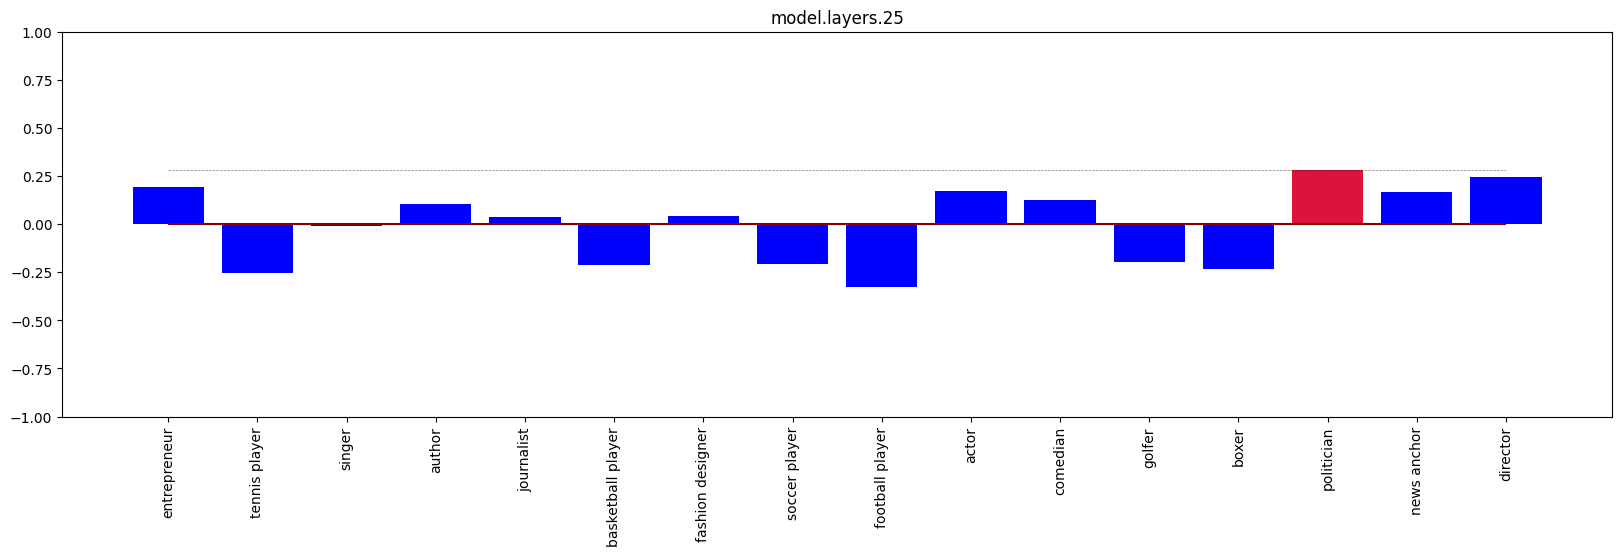

2025-08-01 17:55:09 __main__ INFO     model.layers.25 = [('politician', 0.283203125), ('director', 0.244140625), ('entrepreneur', 0.1943359375), ('actor', 0.173828125), ('news anchor', 0.1669921875), ('comedian', 0.1259765625), ('author', 0.10400390625), ('fashion designer', 0.0400390625), ('journalist', 0.038330078125), ('singer', -0.0107421875), ('golfer', -0.197265625), ('soccer player', -0.208984375), ('basketball player', -0.2119140625), ('boxer', -0.2353515625), ('tennis player', -0.251953125), ('football player', -0.328125)]


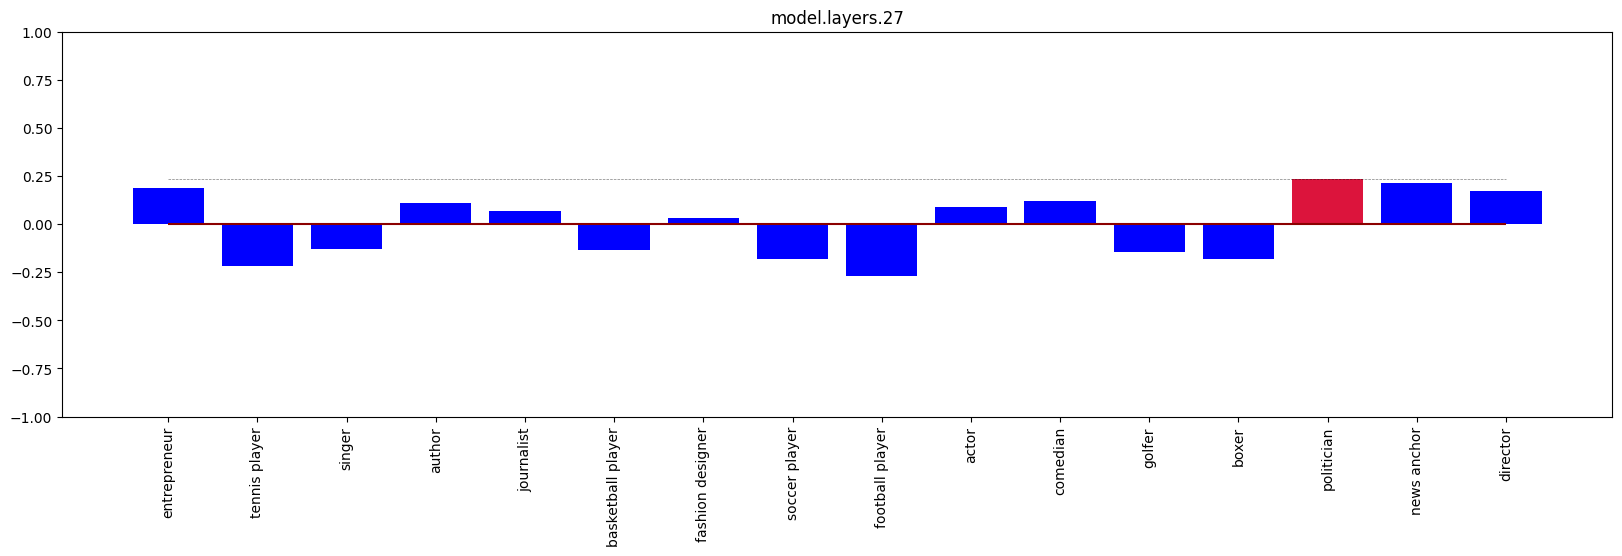

2025-08-01 17:55:09 __main__ INFO     model.layers.27 = [('politician', 0.2333984375), ('news anchor', 0.2119140625), ('entrepreneur', 0.189453125), ('director', 0.169921875), ('comedian', 0.11962890625), ('author', 0.10888671875), ('actor', 0.08984375), ('journalist', 0.0673828125), ('fashion designer', 0.03173828125), ('singer', -0.130859375), ('basketball player', -0.1337890625), ('golfer', -0.14453125), ('soccer player', -0.18359375), ('boxer', -0.18359375), ('tennis player', -0.2197265625), ('football player', -0.271484375)]


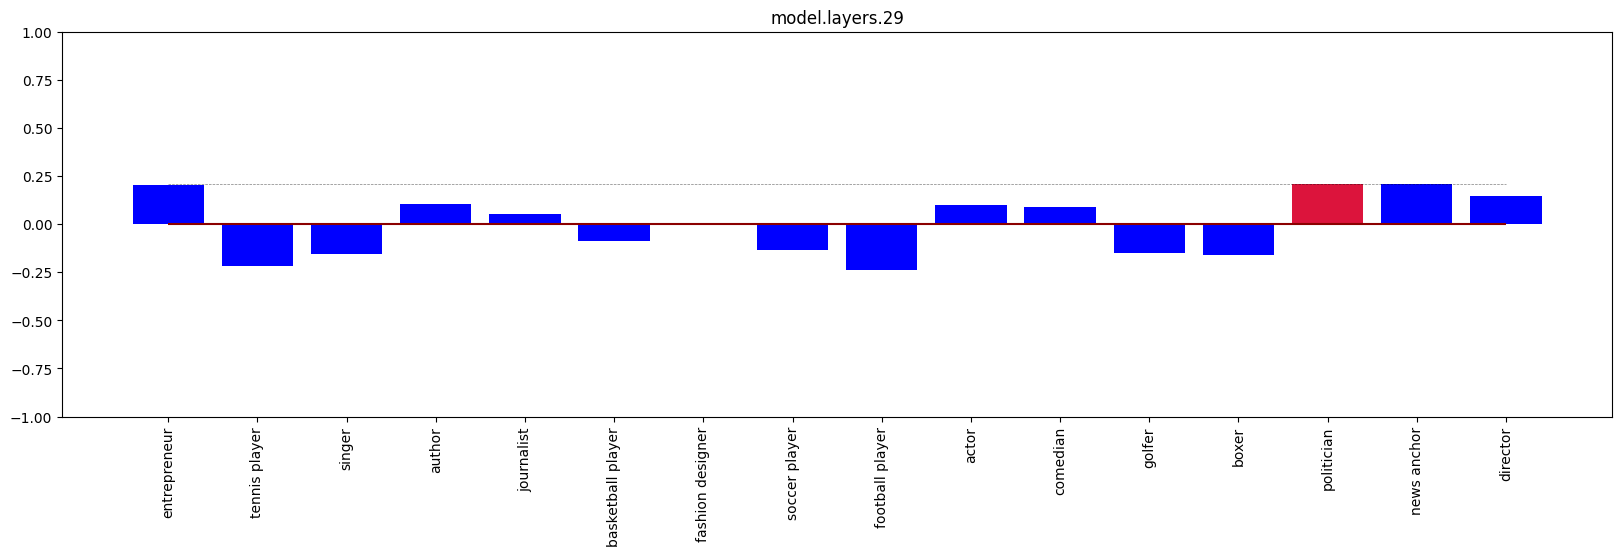

2025-08-01 17:55:09 __main__ INFO     model.layers.29 = [('news anchor', 0.2099609375), ('politician', 0.208984375), ('entrepreneur', 0.205078125), ('director', 0.1474609375), ('author', 0.10302734375), ('actor', 0.10107421875), ('comedian', 0.0908203125), ('journalist', 0.0537109375), ('fashion designer', 0.000865936279296875), ('basketball player', -0.08984375), ('soccer player', -0.134765625), ('golfer', -0.1484375), ('singer', -0.15625), ('boxer', -0.16015625), ('tennis player', -0.2197265625), ('football player', -0.2373046875)]


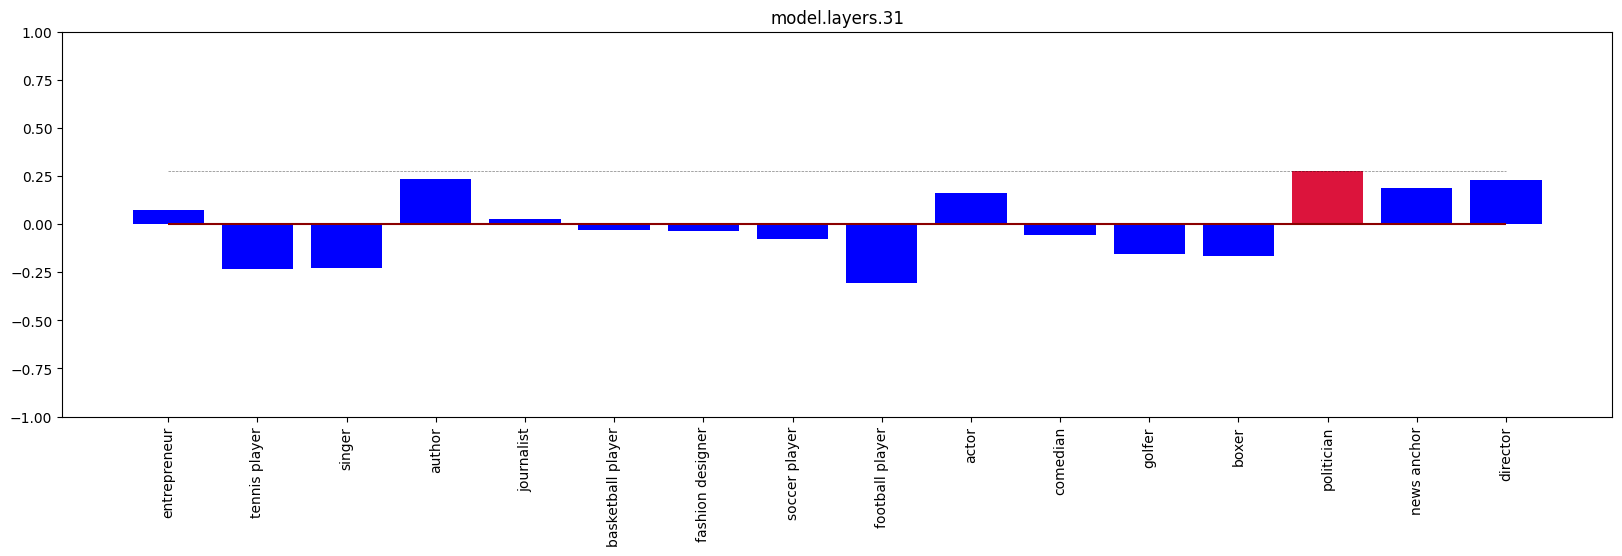

2025-08-01 17:55:10 __main__ INFO     model.layers.31 = [('politician', 0.27734375), ('author', 0.236328125), ('director', 0.228515625), ('news anchor', 0.185546875), ('actor', 0.1630859375), ('entrepreneur', 0.0703125), ('journalist', 0.02392578125), ('basketball player', -0.0299072265625), ('fashion designer', -0.037353515625), ('comedian', -0.057373046875), ('soccer player', -0.078125), ('golfer', -0.1533203125), ('boxer', -0.1650390625), ('singer', -0.2294921875), ('tennis player', -0.2333984375), ('football player', -0.3046875)]


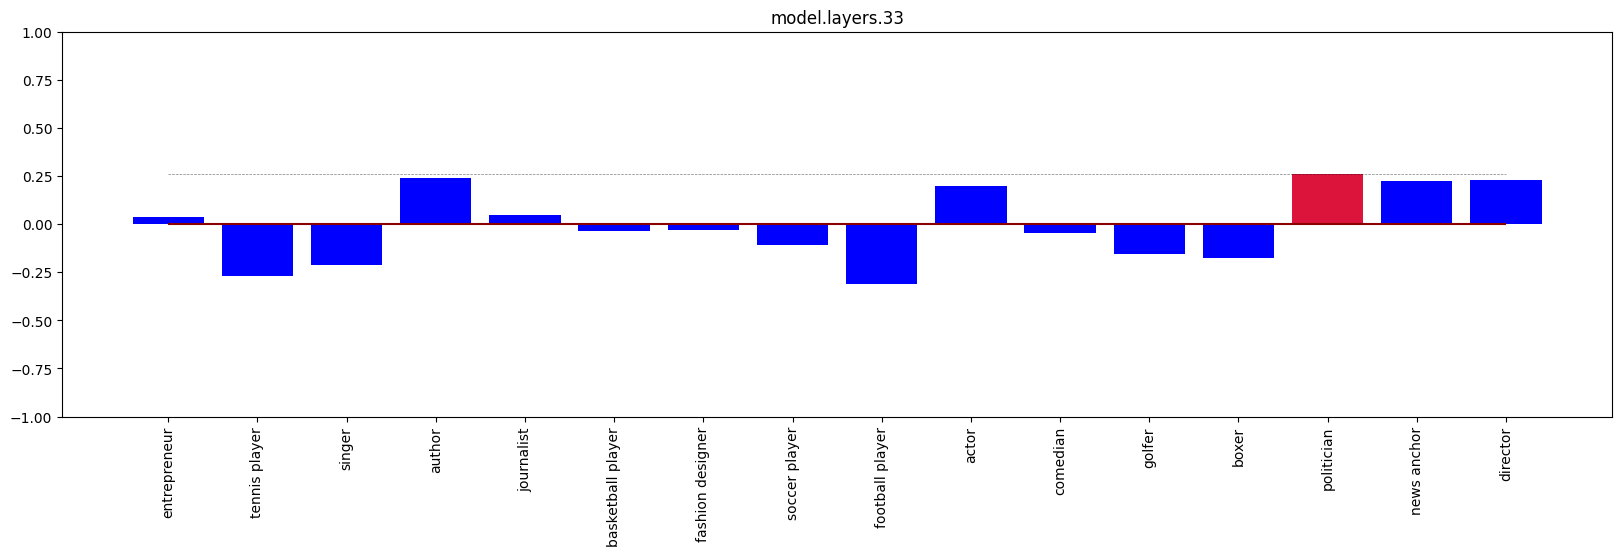

2025-08-01 17:55:10 __main__ INFO     model.layers.33 = [('politician', 0.26171875), ('author', 0.23828125), ('director', 0.228515625), ('news anchor', 0.22265625), ('actor', 0.1982421875), ('journalist', 0.04931640625), ('entrepreneur', 0.03466796875), ('fashion designer', -0.031005859375), ('basketball player', -0.0361328125), ('comedian', -0.046875), ('soccer player', -0.1064453125), ('golfer', -0.1552734375), ('boxer', -0.17578125), ('singer', -0.2138671875), ('tennis player', -0.267578125), ('football player', -0.3125)]


In [33]:
from src.functional import get_hs

sample = patch_sample
# sample = clean_sample
locations = [
    (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)
]
# locations = [(mt.layer_name_format.format(35), -1)]

hs = get_hs(mt=mt, input=sample.prompt, locations=locations, return_dict=True)
hs = {layer_name: latent for (layer_name, token_idx), latent in hs.items()}

layers = [
    mt.layer_name_format.format(layer_idx)
    for layer_idx in list(set(list(range(0, mt.n_layer, 5)) + list(range(30, 40))))
]
layerwise_scores = mean_probes.apply_all_layers(
    hs=hs,
    layer_names=hs.keys(),
)

# evolution_of_scores = MeanProbes.get_evolution_of_scores(
#     scores=layerwise_scores,
#     correct_concept=sample.metadata["category"],
# )

# plt.figure(figsize=(10, 5))
# plt.plot(range(len(evolution_of_scores)),evolution_of_scores, marker='o', markersize=3, alpha=0.7)
# plt.xlabel("Layer Index")
# plt.ylabel("Score Difference")
# # plt.xticks(layer_indices, rotation=90)
# plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
# plt.show()

MeanProbes.bar_chart_per_layer(
    scores={
        layer_name: layerwise_scores[layer_name]
        for layer_name in [
            mt.layer_name_format.format(layer_idx) for layer_idx in range(25, 35, 2)
        ]
    },
    highlight_categories=[sample.metadata["attribute"]],
)

In [24]:
# scale_up
from src.selection.data import get_random_sample
from src.functional import get_hs
import matplotlib.pyplot as plt
import numpy as np
from src.utils import experiment_utils


N_SAMPLES = 10
N_DISTRACTORS = 5

experiment_utils.set_seed(123456)
evolution_of_scores = []
for run_idx in range(N_SAMPLES):
    print(f"run {run_idx + 1}/{N_SAMPLES}...")
    sample = get_random_sample(
        people_by_category=people_by_category,
        mt = mt,
        n_distractors=N_DISTRACTORS,
        filter_by_lm_prediction= True,
    )

    hs = get_hs(
        mt=mt,
        input=sample.prompt,
        locations=[
            (mt.layer_name_format.format(layer_idx), -1)
            for layer_idx in range(mt.n_layer)
        ],
        return_dict=True,
    )
    hs = {layer_name: latent for (layer_name, token_idx), latent in hs.items()}
    evolution_of_scores.append(
        MeanProbes.get_evolution_of_scores(
            scores=mean_probes.apply_all_layers(
                hs=hs,
                layer_names=hs.keys(),
            ),
            correct_concept=sample.metadata["attribute"],
        )
    )

evolution_of_scores = np.array(evolution_of_scores)

2025-08-01 17:52:20 src.utils.experiment_utils INFO     setting all seeds to 123456


run 1/10...
run 2/10...
run 3/10...
run 4/10...
run 5/10...
run 6/10...
run 7/10...
run 8/10...
run 9/10...
run 10/10...


Text(0, 0.5, 'score(target) - max(score(other categories))')

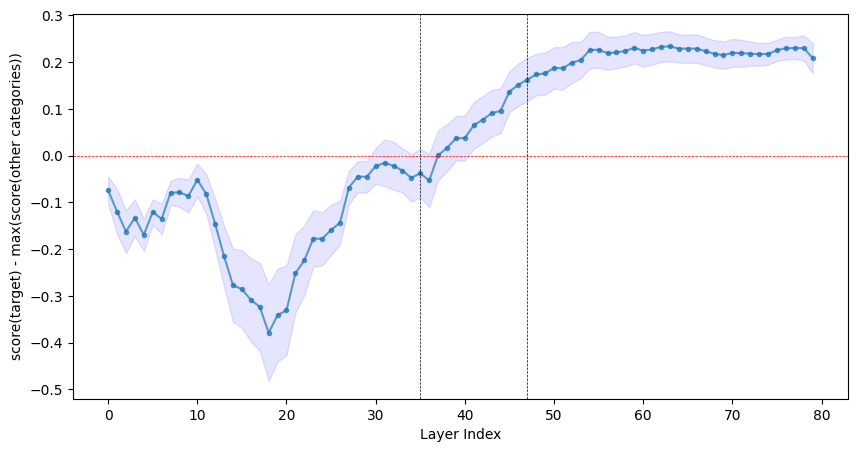

In [25]:
means = np.mean(evolution_of_scores, axis=0)
sterr = np.std(evolution_of_scores, axis=0) / np.sqrt(N_SAMPLES)

plt.figure(figsize=(10, 5))
plt.plot(
    range(len(means)),
    means,
    marker='o',
    alpha=0.7,
    markersize=3,
    label='Mean Score Difference'
)
plt.fill_between(
    range(len(means)),
    means - sterr,
    means + sterr,
    color='blue',
    alpha=0.1,
    label='Standard Error'
)

plt.axhline(0, color='red', linestyle='--', linewidth=0.5)
plt.axvline(35, color='black', linestyle='--', linewidth=0.5)
plt.axvline(47, color='black', linestyle='--', linewidth=0.5)


plt.xlabel("Layer Index")
plt.ylabel("score(target) - max(score(other categories))")

### Steering

In [38]:
from src.functional import PatchSpec
from src.attention import get_attention_matrices, visualize_attn_matrix, visualize_average_attn_matrix

promote_concept = patch_sample.metadata["attribute"]
suppress_concept = clean_sample.metadata["attribute"]

promote_directions = probe_directions[promote_concept]
suppress_directions = probe_directions[suppress_concept]
beta = 1

tokenized = prepare_input(
    prompts=clean_sample.prompt,
    tokenizer=mt,
)

clean_hs = get_hs(
    mt=mt,
    input=tokenized,
    locations=[
        (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)
    ],
    return_dict=True,
)
patch_hs = []
for layer_idx in range(34, 35):
    layer_name = mt.layer_name_format.format(layer_idx)
    promote_dir = promote_directions[layer_name].to(mt.dtype).to(mt.device)
    suppress_dir = suppress_directions[layer_name].to(mt.dtype).to(mt.device)

    orig_h = clean_hs[(layer_name, -1)].to(mt.dtype).to(mt.device)

    #! Doesn't work as expected (query_proj works on post-LN space. But the interventions are done on pre-LN space)
    # attn_module = baukit.get_module(
    #     mt._model,
    #     mt.attn_module_name_format.format(layer_idx + 1),
    # )
    # q_proj_weight_split = attn_module.q_proj.weight.view(
    #     N_HEADS, attn_module.head_dim, attn_module.q_proj.in_features
    # )

    # deltas = []
    # for head_idx in [19]:
    #     head_q_proj_weight = q_proj_weight_split[head_idx]
    #     with torch.no_grad():
    #         head_q_proj = head_q_proj_weight.to(torch.float32)
    #         # proj_matrix = head_q_proj.T @ torch.linalg.pinv(head_q_proj @ head_q_proj.T) @ head_q_proj
    #         # head_query_read = head_inp @ proj_matrix.to(mt.dtype).T
    #         U, S, Vt = torch.linalg.svd(head_q_proj, full_matrices=False)
    #         Vt = Vt.to(mt.dtype).to(head_inp.device)
    #         head_query_read = head_inp @ Vt.T @ Vt
        
    #     head_query_read = inverse_rms_norm(
    #         head_query_read[:, -1].squeeze(), input_ln.weight, input_ln.variance_epsilon
    #     ).to(mt.dtype).to(mt.device)
    #     h_suppress = (
    #         torch.dot(head_query_read, suppress_dir)
    #         / suppress_dir.norm() ** 2
    #         * suppress_dir
    #     )
    #     h_promote = (
    #         torch.dot(head_query_read, promote_dir)
    #         / promote_dir.norm() ** 2
    #         * promote_dir
    #     )
    #     deltas.append(
    #         h_promote - h_suppress
    #     )
    
    # patch_h = orig_h.clone()
    # for delta in deltas:
    #     patch_h += beta * delta

    # ! Uncommenting this will have the desired effect
    h_suppress = (
        torch.dot(orig_h, suppress_dir) / suppress_dir.norm() ** 2 * suppress_dir
    )
    h_promote = torch.dot(orig_h, promote_dir) / promote_dir.norm() ** 2 * promote_dir
    patch_h = orig_h + beta * (h_promote - h_suppress)

    patch_hs.append(
        PatchSpec(location=(layer_name, -1), patch=patch_h.to(mt.dtype).to(mt.device))
    )

steered_attn_matrices = get_attention_matrices(
    input=clean_tokenized, mt=mt, value_weighted=False, 
    patches=patch_hs
)

# for group_id in group_id_to_head_indices:
layer_idx = 35
for group_id in [19, 46]:
    frm = group_id_to_head_indices[group_id][0]
    to = group_id_to_head_indices[group_id][-1]
    print(
        f"Layer {layer_idx}, Group {group_id} (Heads {frm}-{to})"
    )
    attn_matrix = (
        torch.Tensor(
            steered_attn_matrices.attention_matrices[layer_idx, frm : to + 1]
        )
        .mean(dim=0)
        .squeeze()
    )

    tokenized = patch_tokenized if run_name == "corrupt" else clean_tokenized
    print(run_name, attn_matrix.shape, tokenized.input_ids.shape)

    visualize_attn_matrix(
        attn_matrix=attn_matrix,
        tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
        q_index=-1,
        start_from=1,
    )
    
    print("=" * 150)

interpret_logits(tokenizer=mt, logits=steered_attn_matrices.logits)

Layer 35, Group 19 (Heads 19-19)


NameError: name 'run_name' is not defined

### Testing with people from the FakeVerse

In [9]:
with open(
    os.path.join(
        env_utils.DEFAULT_DATA_DIR, "synthetic_entities", "64", "profiles.json"
    ),
    "r",
) as f:
    fakeverse = json.load(f)

fakeverse = {profile["name"]: profile for profile in fakeverse}

list(fakeverse["Ali Rezaei"].keys())

['name',
 'nationality',
 'language',
 'occupation',
 'university',
 'degree',
 'hobby',
 'pet',
 'type_of_car',
 'allergy',
 'favorite_food',
 'favorite_drink',
 'favorite_music_genre',
 'favorite_sport',
 'favorite_boardgame',
 'favorite_color',
 'favorite_city',
 'biggest_fear']

In [30]:
from src.selection.data  import load_people_by_category_fakeverse, load_people_by_category

people_by_category = load_people_by_category(tokenizer = mt.tokenizer)
list(people_by_category.keys())

2025-08-01 18:07:18 src.selection.data INFO     Loaded 16 categories


['actor',
 'singer',
 'comedian',
 'director',
 'basketball player',
 'football player',
 'soccer player',
 'tennis player',
 'golfer',
 'boxer',
 'news anchor',
 'journalist',
 'author',
 'fashion designer',
 'entrepreneur',
 'politician']

In [240]:
from src.selection.data import SelectionSample, get_random_sample
from src.functional import generate_with_patch

synth_entity = "Jack Wilson"
# synth_entity = "Takeshi Yamamoto"
# synth_entity = "Elara Vance"
# synth_entity = "Ayse Kaya"
# synth_entity = "Rachel Levy"
# synth_entity = "James Mwangi"
# synth_entity = "Sarah MacDonald"
# synth_entity = "Jose Cruz"
# synth_entity = "James Mitchell"
# synth_entity = "Grace Wanjiru"
# synth_entity = "Camila Torres"
# synth_entity = "Maria dela Rosa"
# synth_entity = "Ji-woo Kim"

prompts = [
    "{} is by profession a",
]

for prompt in prompts:
    gen = generate_with_patch(
        mt = mt,
        inputs = prompt.format(synth_entity),
        n_gen_per_prompt=1,
        remove_prefix=True,
        do_sample=False,
    )[0]
    print(f"{prompt.format(synth_entity)} >> {gen}")

sample = get_random_sample(
    people_by_category = people_by_category,
    mt = mt,
    n_distractors=5,
    get_alt_obj=True,
    attribute=fakeverse[synth_entity]["occupation"],
    obj_idx=3,
    filter_by_lm_prediction=True,
    exclude_distractor_categories=["tennis player"]
)
print(sample)
sample.prediction

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Jack Wilson is by profession a >>  journalist, hailing from France. He is a graduate of York University, where he earned a Bachelor
Maggie Haberman -> Jane Mayer (3): ['Dmitry Bivol', 'Son Heung-min', 'Denis Villeneuve', 'Jane Mayer', 'Rory McIlroy', 'Donald Trump']


[PredictedToken(token=' Jane', prob=0.7734375, logit=20.25, token_id=22195, metadata=None),
 PredictedToken(token=' The', prob=0.11865234375, logit=18.375, token_id=578, metadata=None),
 PredictedToken(token=' Maggie', prob=0.033935546875, logit=17.125, token_id=62795, metadata=None),
 PredictedToken(token=' \n', prob=0.006683349609375, logit=15.5, token_id=720, metadata=None),
 PredictedToken(token=' ', prob=0.00628662109375, logit=15.4375, token_id=220, metadata=None)]

In [242]:
print("=" * 50)
sample.options[sample.obj_idx] = synth_entity

#! match with the fake entity
# prompt = sample.prompt
# print(prompt, ">>", synth_entity)

#! fake entity as the pivot
prompt_template = sample.prompt.replace(sample.match_with, "{}").replace(synth_entity, "{}")
prompt = prompt_template.format(synth_entity, sample.match_with)
print(prompt, ">>", sample.match_with)

generate_with_patch(
    mt = mt,
    inputs = prompt,
    n_gen_per_prompt=1,
    remove_prefix=True,
    do_sample=False,
)[0]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Which person from the following list has their occupation in common with Jack Wilson?
Options: Dmitry Bivol, Son Heung-min, Denis Villeneuve, Maggie Haberman, Rory McIlroy, Donald Trump.
Ans: >> Maggie Haberman


' None of the above. Jack Wilson is a journalist. None of the people listed are journalists.'

In [243]:
from src.functional import predict_next_token, generate_with_patch

options = sample.options
options[sample.obj_idx] = sample.match_with
test_attr = """Who among the following people is by profession a {}?
{}
Answer:"""
test_attr = test_attr.format(
    sample.metadata["attribute"],
    "\n".join([f"{idx + 1}. {option}" for idx, option in enumerate(options)]),
)

gen = generate_with_patch(
    mt = mt,
    inputs = test_attr,
    n_gen_per_prompt=1,
    remove_prefix=True,
    do_sample=False
)[0]

print(f"{test_attr} >> {gen}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Who among the following people is by profession a journalist?
1. Dmitry Bivol
2. Son Heung-min
3. Denis Villeneuve
4. Maggie Haberman
5. Rory McIlroy
6. Donald Trump
Answer: >>  Maggie Haberman
Maggie Haberman is a journalist by profession. She is an American journalist


In [ ]:
from src.tokens import find_token_range, prepare_input
from src.functional import patchscope, get_hs
from itertools import product

tokenized = prepare_input(
    prompts=prompt,
    tokenizer=mt,
    return_offsets_mapping=True,
)

offset_mapping = tokenized.pop("offset_mapping")[0]

subj_range = find_token_range(
    string=prompt,
    substring=synth_entity,
    offset_mapping=offset_mapping,
    tokenizer=mt,
    occurrence=-1,
)

print(
    f'"{synth_entity}" | {subj_range=} | "{mt.tokenizer.decode(tokenized.input_ids[0][range(*subj_range)])}"'
)

options = sample.options
options[sample.obj_idx] = sample.match_with
option_ranges = []

for option in options:
    option_range = find_token_range(
        string=prompt,
        substring=option,
        offset_mapping=offset_mapping,
        tokenizer=mt,
        occurrence=-1,
    )
    print(
        f'"{option}" | {option_range=} | "{mt.tokenizer.decode(tokenized.input_ids[0][range(*option_range)])}"'
    )
    option_ranges.append(option_range)

pred_range = (-2, 0)
token_ranges = [pred_range, subj_range] + option_ranges
token_indices = []
for rng in token_ranges:
    token_indices.extend(list(range(rng[0], rng[1])))

layers = mt.layer_names
locations = list(product(layers, token_indices))

hs = get_hs(mt=mt, input=tokenized, locations=locations, patches=[], return_dict=True)


########################################################################
context_prof = """Name of a person -> their profession
Albert Einstein -> physicist
Michael Jordan -> basketball player
Jack Ma -> entrepreneur
placeholder ->"""

patch_layers = [5]
patch_layers = [mt.layer_name_format.format(idx) for idx in patch_layers]
########################################################################

context = context_prof
context_tok = prepare_input(
    prompts=context_prof, tokenizer=mt, return_offsets_mapping=True
)
cxt_offset_mapping = context_tok.pop("offset_mapping")[0]

h_idx = (
    find_token_range(
        string=context,
        substring="placeholder",
        offset_mapping=cxt_offset_mapping,
        tokenizer=mt.tokenizer,
        occurrence=-1,
    )[1]
    - 1
)

for layer in mt.layer_names[25:45:2] + mt.layer_names[65: 80: 2]:
    print(f"\n{layer=}")
    for cur_rng in token_ranges:
        print(
            f'\n"{mt.tokenizer.decode(tokenized.input_ids[0][range(*cur_rng)])}" | {cur_rng=}'
        )
        for token_idx in range(cur_rng[0], cur_rng[1]):
            token = mt.tokenizer.decode(tokenized.input_ids[0][token_idx])
            ll_pred = patchscope(
                mt=mt,
                h=hs[(layer, token_idx)],
                context=context,
                placeholder="placeholder",
                context_tokenized=context_tok,
                placeholder_idx=h_idx,
                patch_layers=patch_layers,
                k=15,
            )
            ll_fmt = [
                f'"{pred.token}"[p={pred.prob:.2f}, l={pred.logit:.2f}]'
                for pred in ll_pred
            ]
            print(f'{token_idx=} ["{token}"] => {ll_fmt}')

    print("=" * 150)

"Jack Wilson" | subj_range=(13, 15) | " Jack Wilson"
"Dmitry Bivol" | option_range=(18, 21) | " Dmitry Bivol"
"Son Heung-min" | option_range=(22, 26) | " Son Heung-min"
"Denis Villeneuve" | option_range=(27, 31) | " Denis Villeneuve"
"Maggie Haberman" | option_range=(32, 35) | " Maggie Haberman"
"Rory McIlroy" | option_range=(36, 40) | " Rory McIlroy"
"Donald Trump" | option_range=(41, 43) | " Donald Trump"

layer='model.layers.25'

"Ans:" | cur_rng=(-2, 0)
token_idx=-2 ["Ans"] => ['"?\n"[p=0.11, l=11.81]', '"?\n\n"[p=0.05, l=10.94]', '"??"[p=0.04, l=10.75]', '" Ans"[p=0.02, l=10.31]', '" programmer"[p=0.02, l=10.25]', '"?"[p=0.02, l=10.25]', '"???"[p=0.02, l=10.12]', '" artist"[p=0.02, l=10.06]', '" computer"[p=0.02, l=10.00]', '" software"[p=0.02, l=9.94]', '" entrepreneur"[p=0.02, l=9.94]', '" unknown"[p=0.02, l=9.88]', '" scientist"[p=0.01, l=9.69]', '" politician"[p=0.01, l=9.62]', '" actor"[p=0.01, l=9.50]']
token_idx=-1 [":"] => ['"?\n"[p=0.24, l=13.62]', '"?\n\n"[p=0.15, l=13.1

In [245]:
print(mt.tokenizer.decode(
    tokenized.input_ids[0]
))

<|begin_of_text|>Which person from the following list has their occupation in common with Jack Wilson?
Options: Dmitry Bivol, Son Heung-min, Denis Villeneuve, Maggie Haberman, Rory McIlroy, Donald Trump.
Ans:


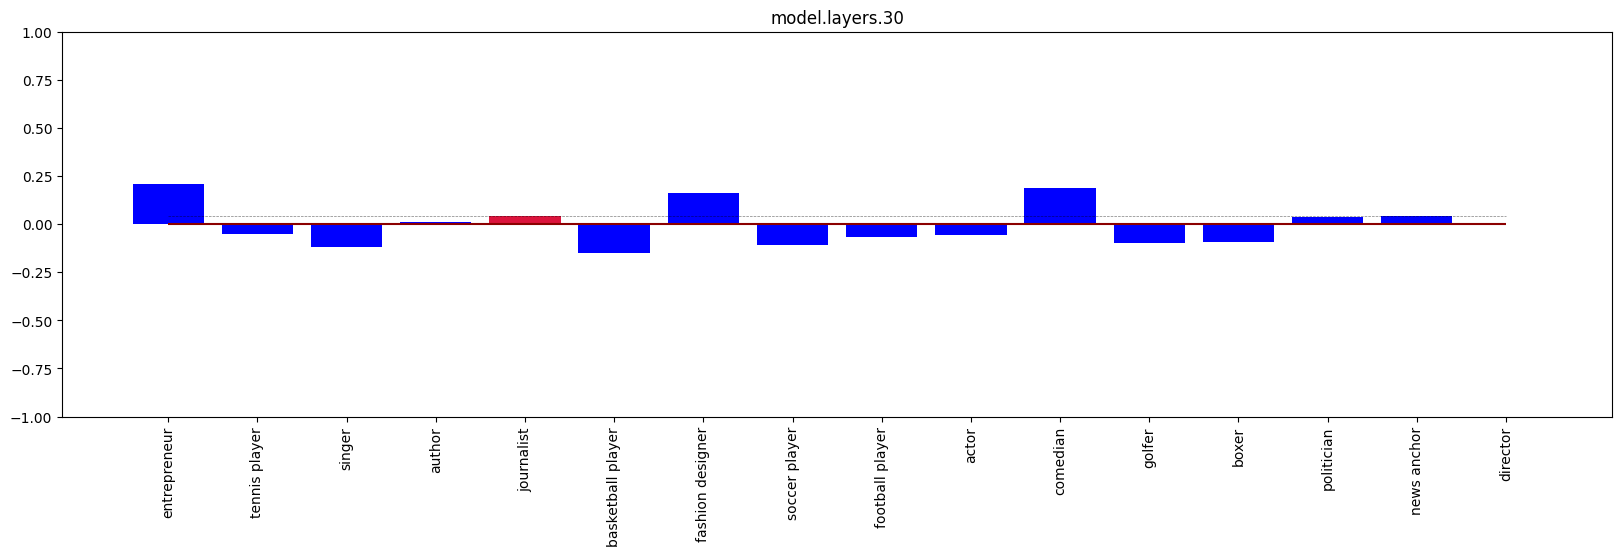

2025-08-04 14:07:29 __main__ INFO     model.layers.30 = [('entrepreneur', 0.208984375), ('comedian', 0.189453125), ('fashion designer', 0.1611328125), ('journalist', 0.040771484375), ('news anchor', 0.040771484375), ('politician', 0.034423828125), ('author', 0.01171875), ('director', 0.0026092529296875), ('tennis player', -0.05126953125), ('actor', -0.054931640625), ('football player', -0.06689453125), ('boxer', -0.091796875), ('golfer', -0.1005859375), ('soccer player', -0.1083984375), ('singer', -0.12060546875), ('basketball player', -0.1494140625)]


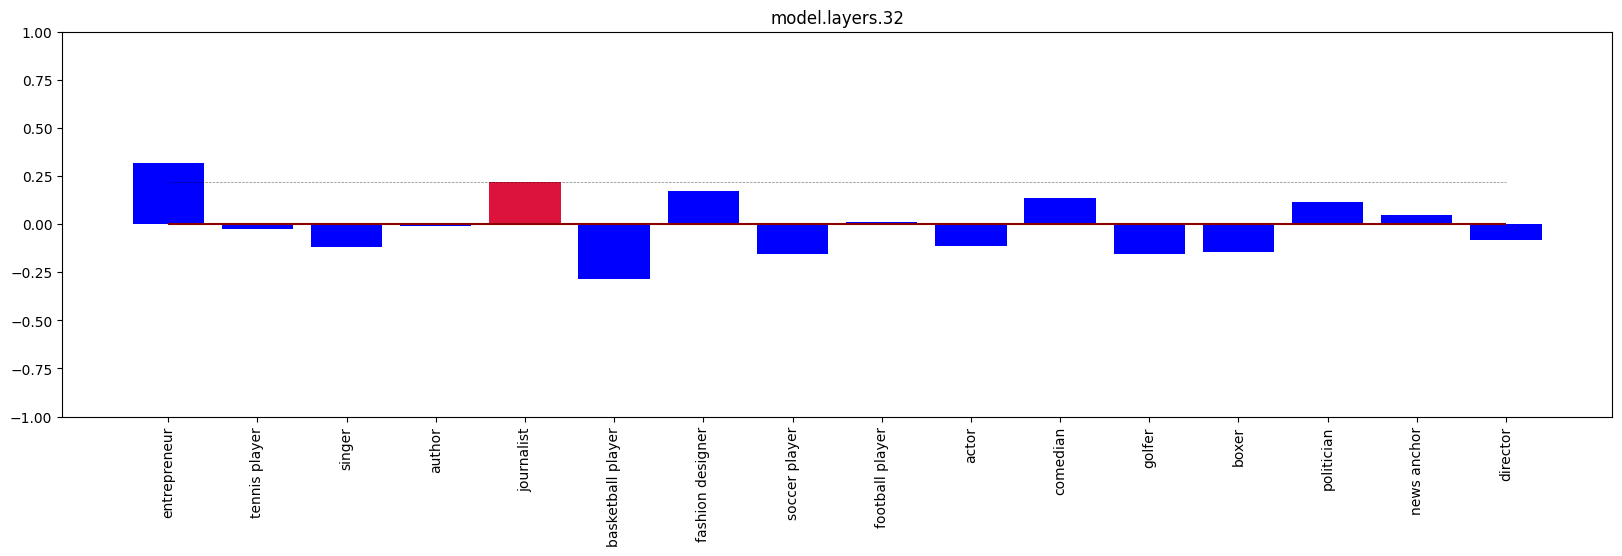

2025-08-04 14:07:29 __main__ INFO     model.layers.32 = [('entrepreneur', 0.314453125), ('journalist', 0.21875), ('fashion designer', 0.169921875), ('comedian', 0.1357421875), ('politician', 0.11328125), ('news anchor', 0.049072265625), ('football player', 0.0123291015625), ('author', -0.01190185546875), ('tennis player', -0.0264892578125), ('director', -0.0830078125), ('actor', -0.1162109375), ('singer', -0.11962890625), ('boxer', -0.1435546875), ('soccer player', -0.154296875), ('golfer', -0.158203125), ('basketball player', -0.28515625)]


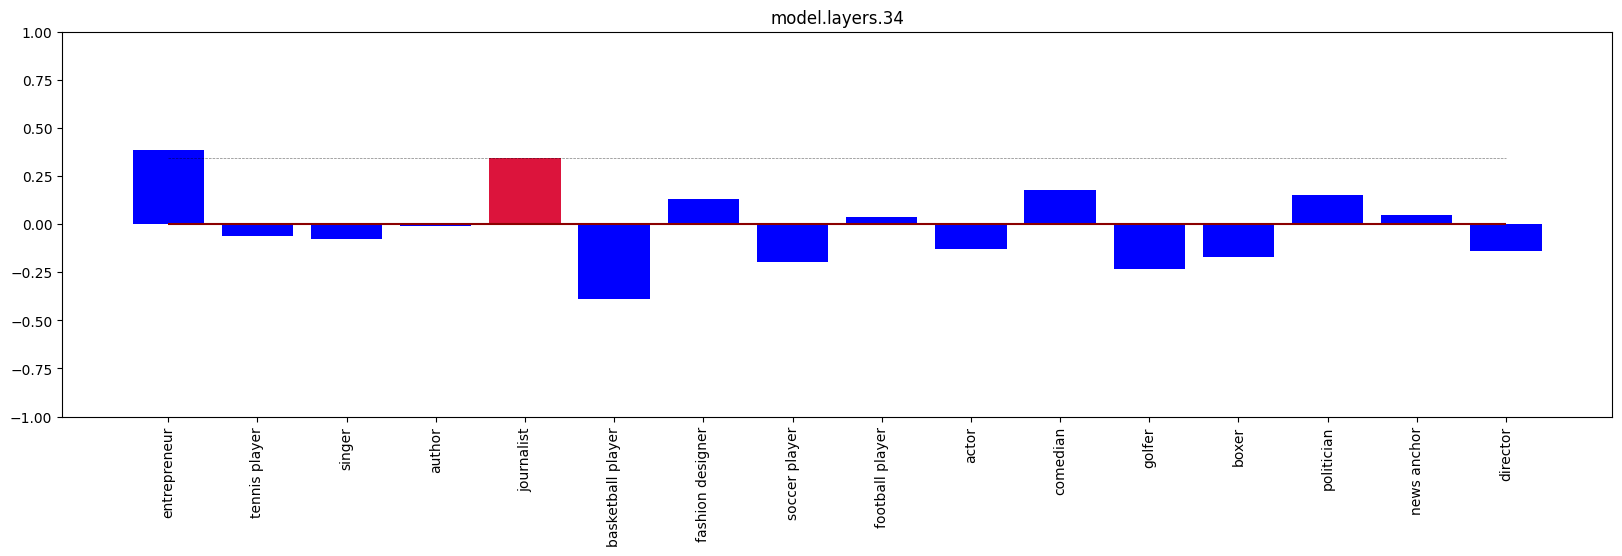

2025-08-04 14:07:29 __main__ INFO     model.layers.34 = [('entrepreneur', 0.3828125), ('journalist', 0.341796875), ('comedian', 0.1787109375), ('politician', 0.15234375), ('fashion designer', 0.1279296875), ('news anchor', 0.048095703125), ('football player', 0.036376953125), ('author', -0.01165771484375), ('tennis player', -0.0634765625), ('singer', -0.0791015625), ('actor', -0.1318359375), ('director', -0.1416015625), ('boxer', -0.171875), ('soccer player', -0.1982421875), ('golfer', -0.2333984375), ('basketball player', -0.388671875)]


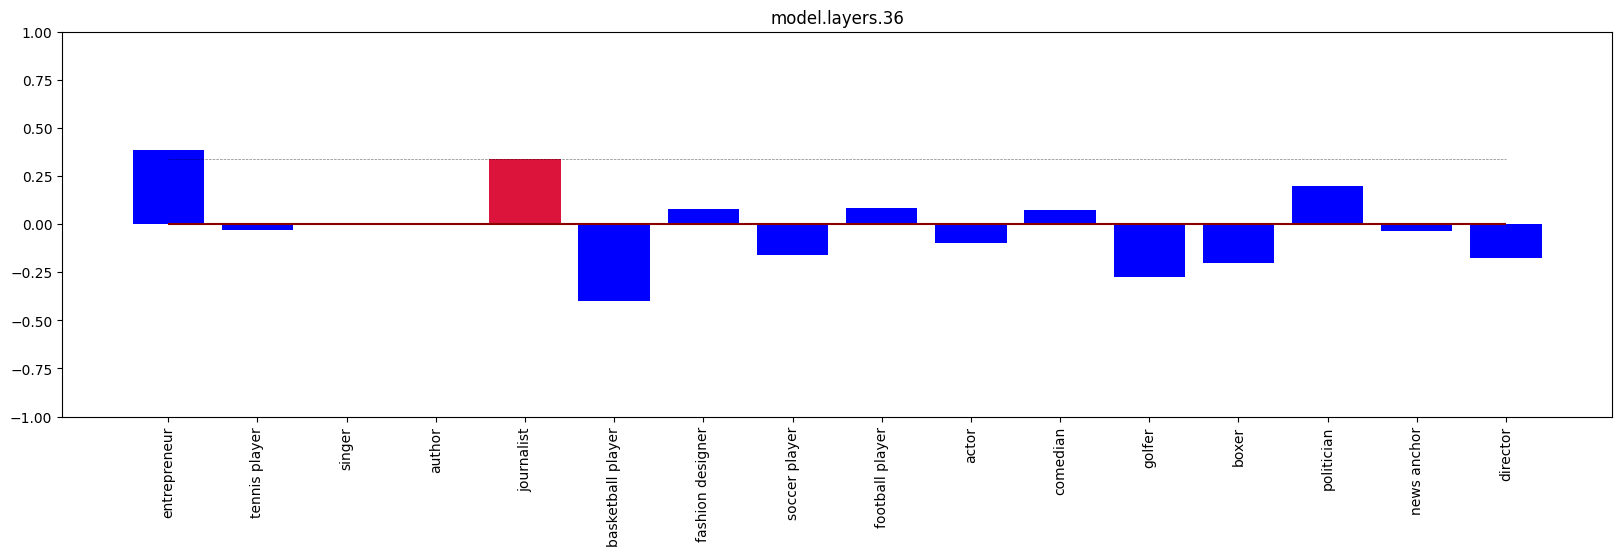

2025-08-04 14:07:29 __main__ INFO     model.layers.36 = [('entrepreneur', 0.384765625), ('journalist', 0.33984375), ('politician', 0.197265625), ('football player', 0.08203125), ('fashion designer', 0.08056640625), ('comedian', 0.0712890625), ('singer', -0.00323486328125), ('author', -0.005706787109375), ('tennis player', -0.0303955078125), ('news anchor', -0.03564453125), ('actor', -0.09814453125), ('soccer player', -0.1611328125), ('director', -0.17578125), ('boxer', -0.2001953125), ('golfer', -0.275390625), ('basketball player', -0.40234375)]


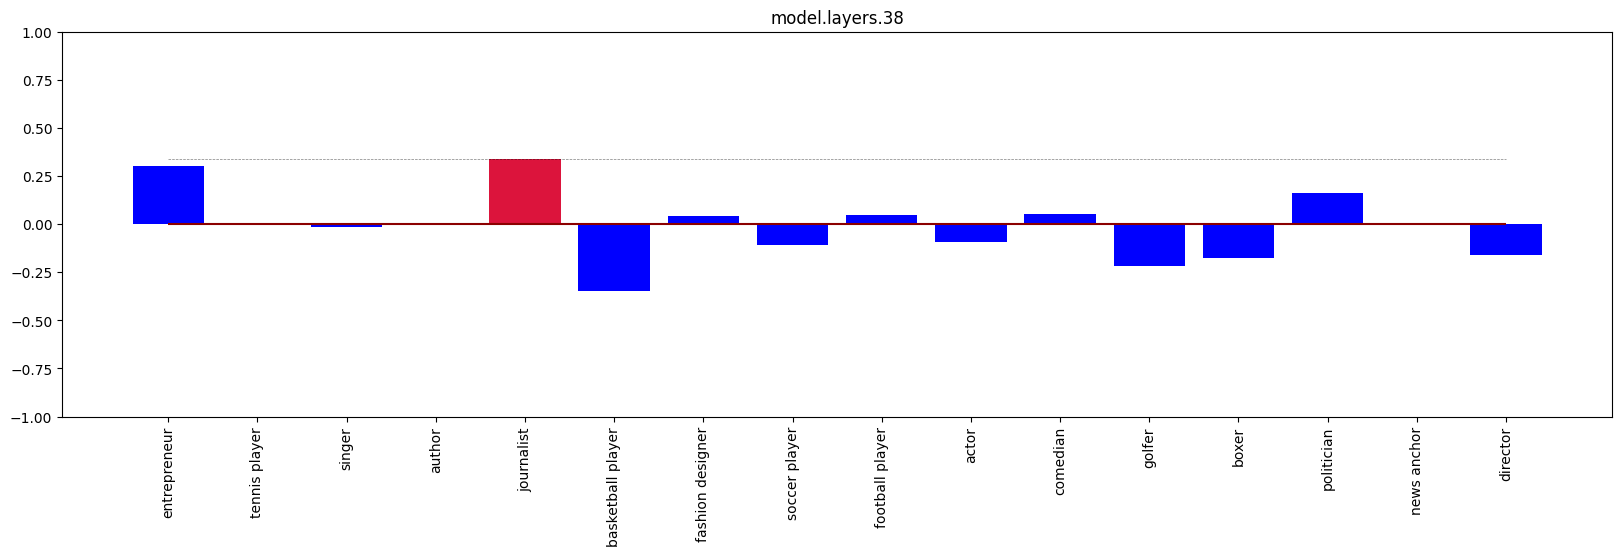

2025-08-04 14:07:29 __main__ INFO     model.layers.38 = [('journalist', 0.337890625), ('entrepreneur', 0.30078125), ('politician', 0.1630859375), ('comedian', 0.05029296875), ('football player', 0.047607421875), ('fashion designer', 0.04296875), ('news anchor', 0.007415771484375), ('author', -0.004180908203125), ('tennis player', -0.0064697265625), ('singer', -0.01708984375), ('actor', -0.09228515625), ('soccer player', -0.10693359375), ('director', -0.162109375), ('boxer', -0.1748046875), ('golfer', -0.2177734375), ('basketball player', -0.345703125)]


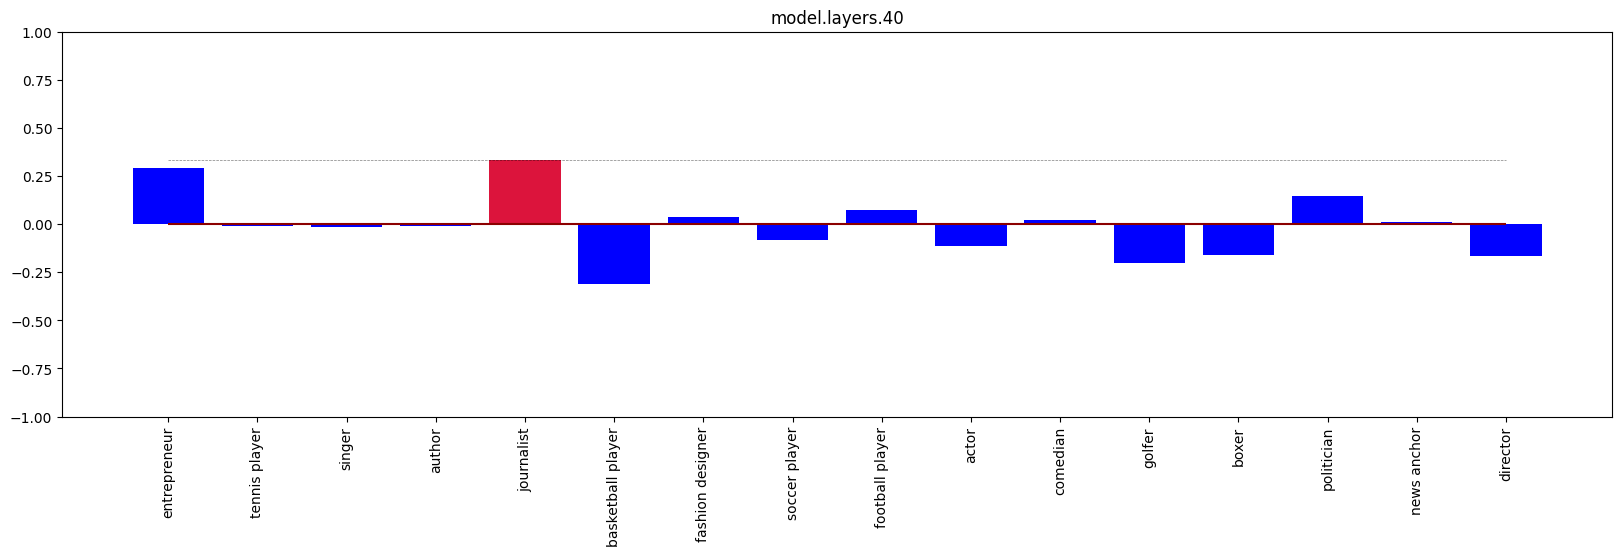

2025-08-04 14:07:29 __main__ INFO     model.layers.40 = [('journalist', 0.333984375), ('entrepreneur', 0.29296875), ('politician', 0.1455078125), ('football player', 0.0751953125), ('fashion designer', 0.03857421875), ('comedian', 0.02099609375), ('news anchor', 0.01300048828125), ('tennis player', -0.01031494140625), ('author', -0.01123046875), ('singer', -0.01611328125), ('soccer player', -0.08447265625), ('actor', -0.1162109375), ('boxer', -0.1591796875), ('director', -0.1669921875), ('golfer', -0.201171875), ('basketball player', -0.3125)]


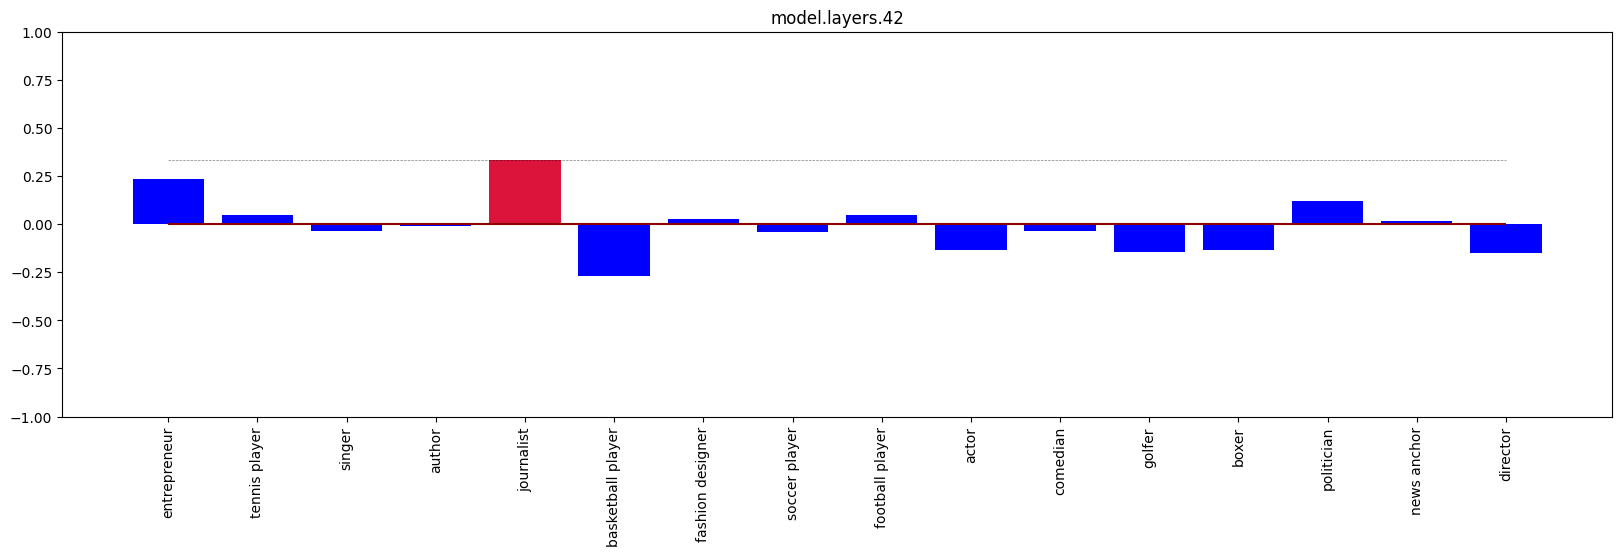

2025-08-04 14:07:30 __main__ INFO     model.layers.42 = [('journalist', 0.33203125), ('entrepreneur', 0.234375), ('politician', 0.12109375), ('football player', 0.049072265625), ('tennis player', 0.048095703125), ('fashion designer', 0.0247802734375), ('news anchor', 0.017578125), ('author', -0.01104736328125), ('singer', -0.03466796875), ('comedian', -0.03466796875), ('soccer player', -0.03955078125), ('actor', -0.1328125), ('boxer', -0.1337890625), ('golfer', -0.1474609375), ('director', -0.15234375), ('basketball player', -0.271484375)]


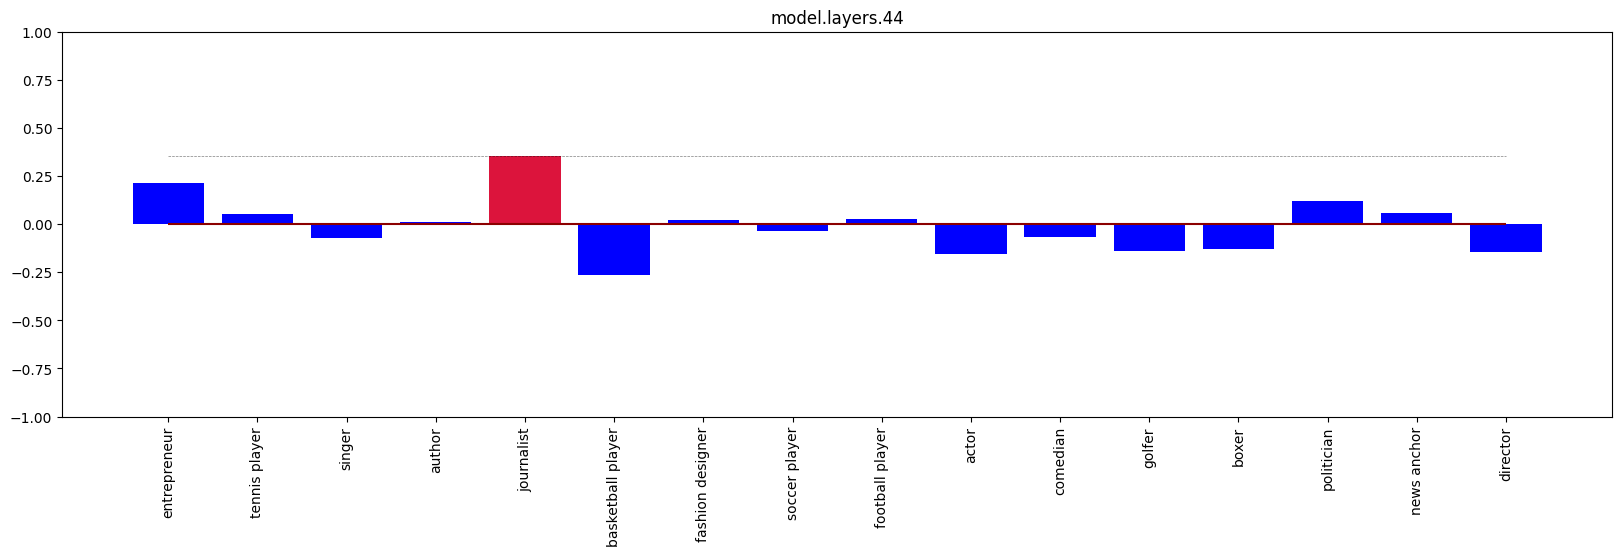

2025-08-04 14:07:30 __main__ INFO     model.layers.44 = [('journalist', 0.35546875), ('entrepreneur', 0.212890625), ('politician', 0.1220703125), ('news anchor', 0.055908203125), ('tennis player', 0.054443359375), ('football player', 0.0283203125), ('fashion designer', 0.0191650390625), ('author', 0.0081787109375), ('soccer player', -0.033935546875), ('comedian', -0.06591796875), ('singer', -0.07080078125), ('boxer', -0.1318359375), ('golfer', -0.138671875), ('director', -0.1435546875), ('actor', -0.15625), ('basketball player', -0.263671875)]


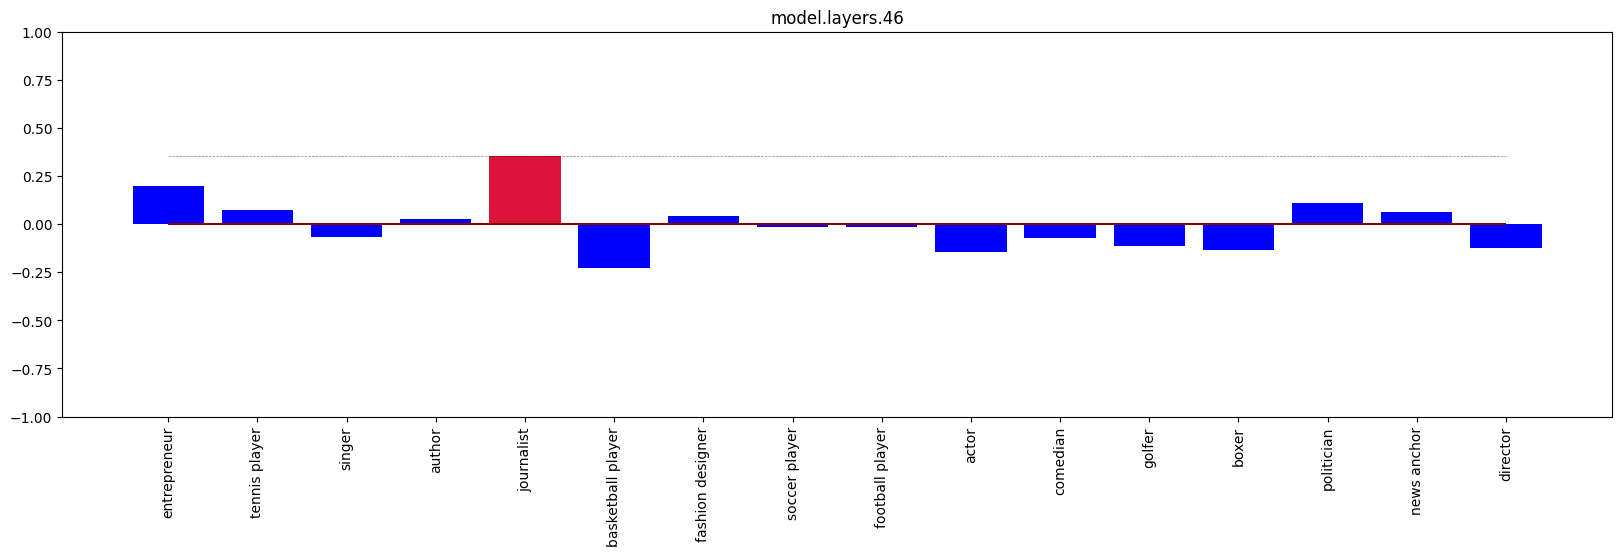

2025-08-04 14:07:30 __main__ INFO     model.layers.46 = [('journalist', 0.35546875), ('entrepreneur', 0.1962890625), ('politician', 0.1103515625), ('tennis player', 0.0712890625), ('news anchor', 0.06005859375), ('fashion designer', 0.042724609375), ('author', 0.0283203125), ('football player', -0.013427734375), ('soccer player', -0.01348876953125), ('singer', -0.0654296875), ('comedian', -0.07421875), ('golfer', -0.11328125), ('director', -0.1259765625), ('boxer', -0.134765625), ('actor', -0.14453125), ('basketball player', -0.228515625)]


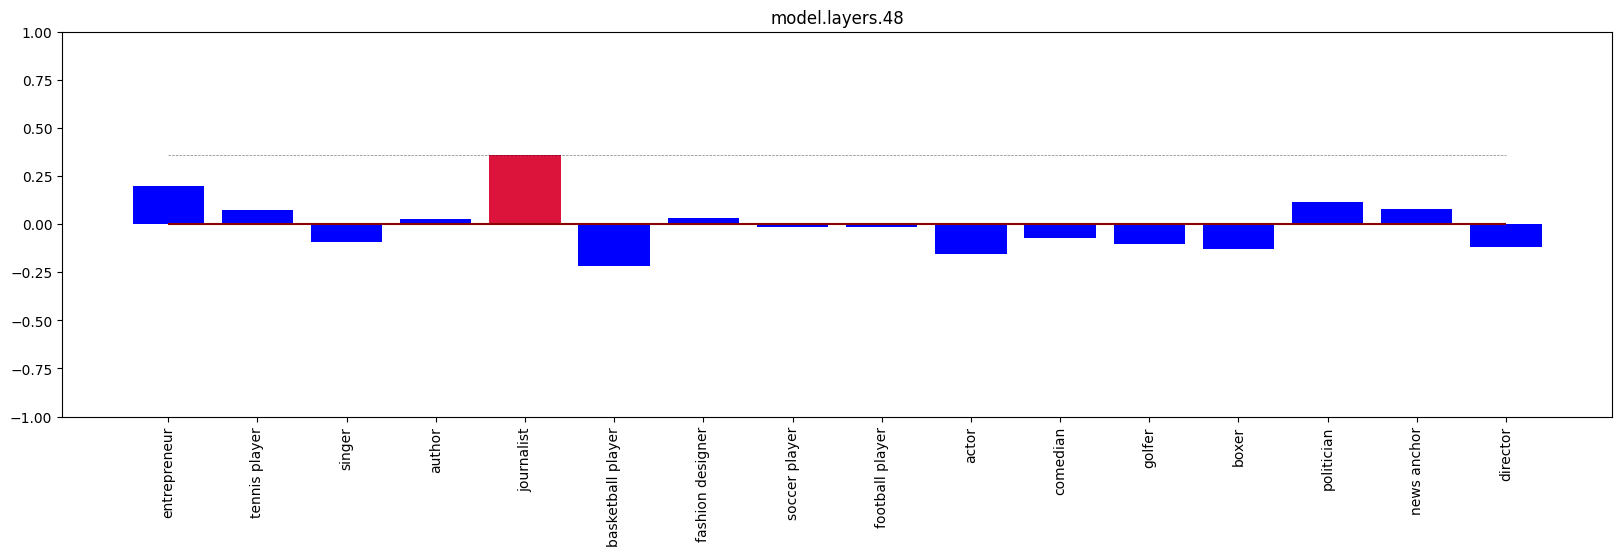

2025-08-04 14:07:30 __main__ INFO     model.layers.48 = [('journalist', 0.359375), ('entrepreneur', 0.1953125), ('politician', 0.11328125), ('news anchor', 0.076171875), ('tennis player', 0.0732421875), ('fashion designer', 0.030517578125), ('author', 0.0257568359375), ('football player', -0.01513671875), ('soccer player', -0.01611328125), ('comedian', -0.0732421875), ('singer', -0.0927734375), ('golfer', -0.103515625), ('director', -0.12158203125), ('boxer', -0.1298828125), ('actor', -0.154296875), ('basketball player', -0.2158203125)]


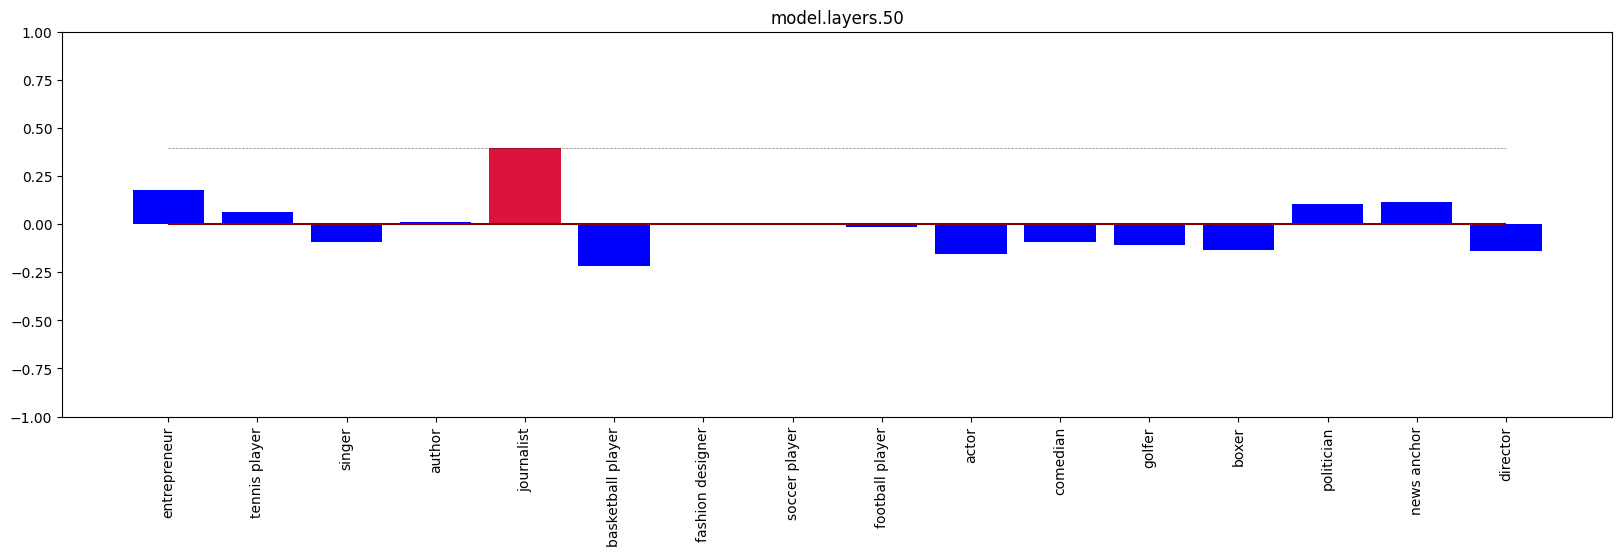

2025-08-04 14:07:30 __main__ INFO     model.layers.50 = [('journalist', 0.39453125), ('entrepreneur', 0.1787109375), ('news anchor', 0.115234375), ('politician', 0.1064453125), ('tennis player', 0.06103515625), ('author', 0.0128173828125), ('fashion designer', -7.867813110351562e-05), ('soccer player', -0.003875732421875), ('football player', -0.015869140625), ('comedian', -0.09375), ('singer', -0.09521484375), ('golfer', -0.1083984375), ('boxer', -0.1328125), ('director', -0.140625), ('actor', -0.1572265625), ('basketball player', -0.216796875)]


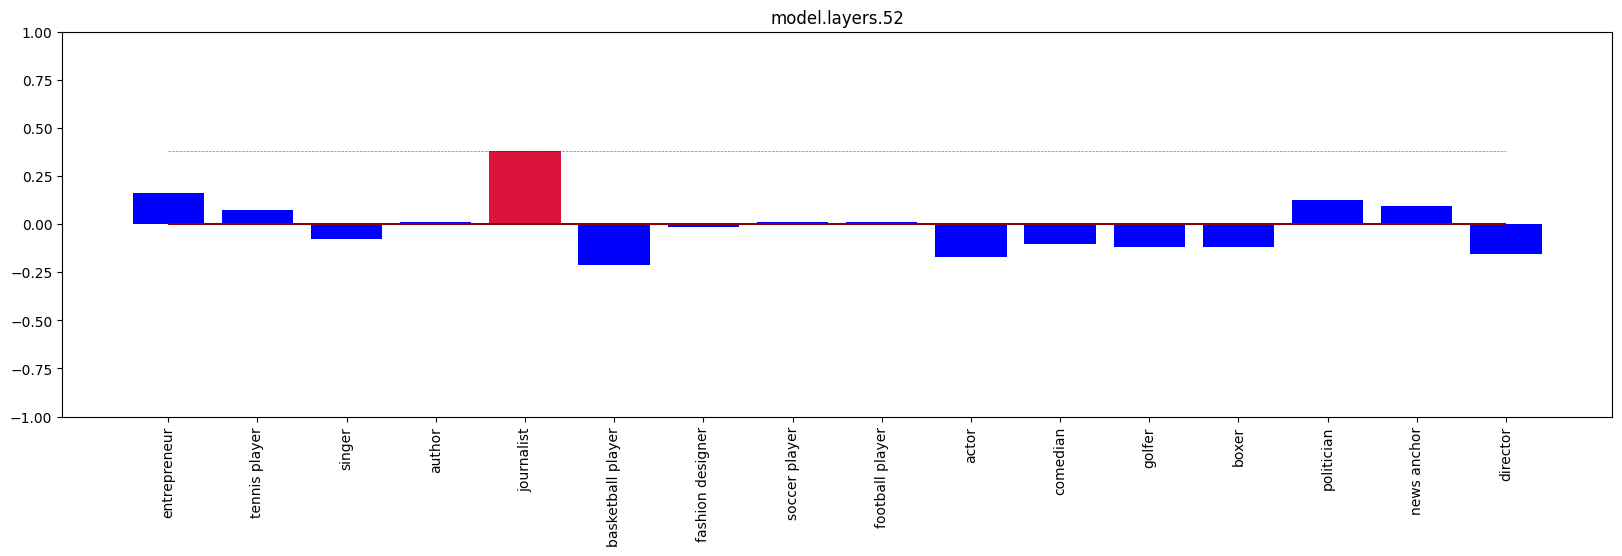

2025-08-04 14:07:30 __main__ INFO     model.layers.52 = [('journalist', 0.376953125), ('entrepreneur', 0.1630859375), ('politician', 0.12451171875), ('news anchor', 0.09326171875), ('tennis player', 0.07275390625), ('author', 0.0130615234375), ('soccer player', 0.0130615234375), ('football player', 0.01043701171875), ('fashion designer', -0.0133056640625), ('singer', -0.080078125), ('comedian', -0.1044921875), ('golfer', -0.11962890625), ('boxer', -0.11962890625), ('director', -0.1533203125), ('actor', -0.169921875), ('basketball player', -0.2138671875)]


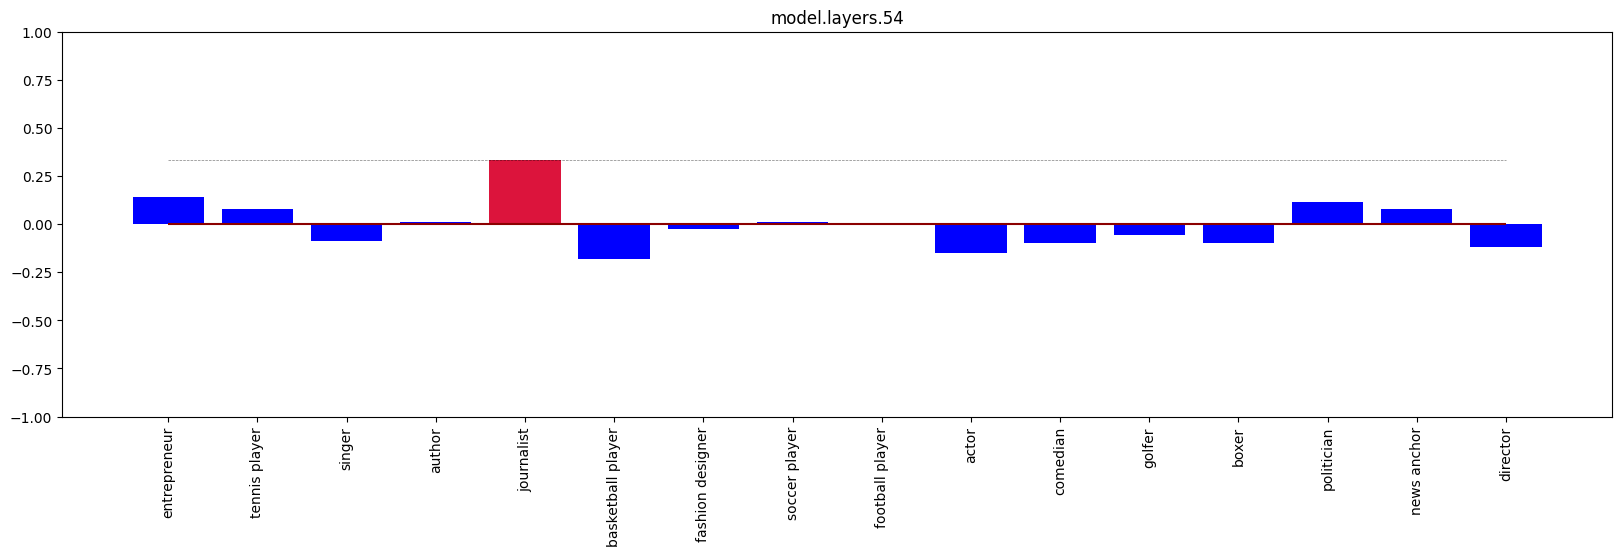

2025-08-04 14:07:31 __main__ INFO     model.layers.54 = [('journalist', 0.33203125), ('entrepreneur', 0.142578125), ('politician', 0.11669921875), ('news anchor', 0.08056640625), ('tennis player', 0.07666015625), ('soccer player', 0.0130615234375), ('author', 0.011474609375), ('football player', 0.003631591796875), ('fashion designer', -0.0250244140625), ('golfer', -0.058349609375), ('singer', -0.08935546875), ('boxer', -0.09814453125), ('comedian', -0.10107421875), ('director', -0.1181640625), ('actor', -0.150390625), ('basketball player', -0.18359375)]
Layer 33, Head 45
Layer 33, Head 18
Layer 34, Head 1
Layer 34, Head 6
Layer 34, Head 7
Layer 35, Head 19
Layer 39, Head 40
Layer 42, Head 30
Layer 47, Head 18
Layer 52, Head 58


[PredictedToken(token=' None', prob=0.2392578125, logit=17.875, token_id=2290, metadata=None),
 PredictedToken(token=' Denis', prob=0.2392578125, logit=17.875, token_id=61703, metadata=None),
 PredictedToken(token=' Dmitry', prob=0.2119140625, logit=17.75, token_id=88231, metadata=None),
 PredictedToken(token=' Maggie', prob=0.07763671875, logit=16.75, token_id=62795, metadata=None),
 PredictedToken(token=' The', prob=0.053466796875, logit=16.375, token_id=578, metadata=None)]

In [246]:
from src.functional import get_hs

locations = [
    (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)
]
# locations = [(mt.layer_name_format.format(35), -1)]

hs = get_hs(mt=mt, input=prompt, locations=locations, return_dict=True)
hs = {layer_name: latent for (layer_name, token_idx), latent in hs.items()}

layerwise_scores = mean_probes.apply_all_layers(
    hs=hs,
    layer_names=hs.keys(),
)

MeanProbes.bar_chart_per_layer(
    scores={
        layer_name: layerwise_scores[layer_name]
        for layer_name in [
            mt.layer_name_format.format(layer_idx) for layer_idx in range(30, 55, 2)
        ]
    },
    highlight_categories=[sample.metadata["attribute"]],
)

tokenized = prepare_input(
    prompts=prompt,
    tokenizer=mt,
)

attn_matrices = get_attention_matrices(
    input=tokenized, mt=mt, value_weighted=False, 
    # patches=patch_hs
)

HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]

selection_head_matrices = []

for layer_idx, head_idx in HEADS:
    print(f"Layer {layer_idx}, Head {head_idx}")
    attn_matrix = (
        torch.Tensor(
            attn_matrices.attention_matrices[layer_idx, head_idx]
        )
        .squeeze()
    )
    selection_head_matrices.append(attn_matrix)

visualize_attn_matrix(
    attn_matrix=torch.stack(selection_head_matrices, dim=0).mean(dim=0),
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

interpret_logits(tokenizer=mt, logits=attn_matrices.logits)

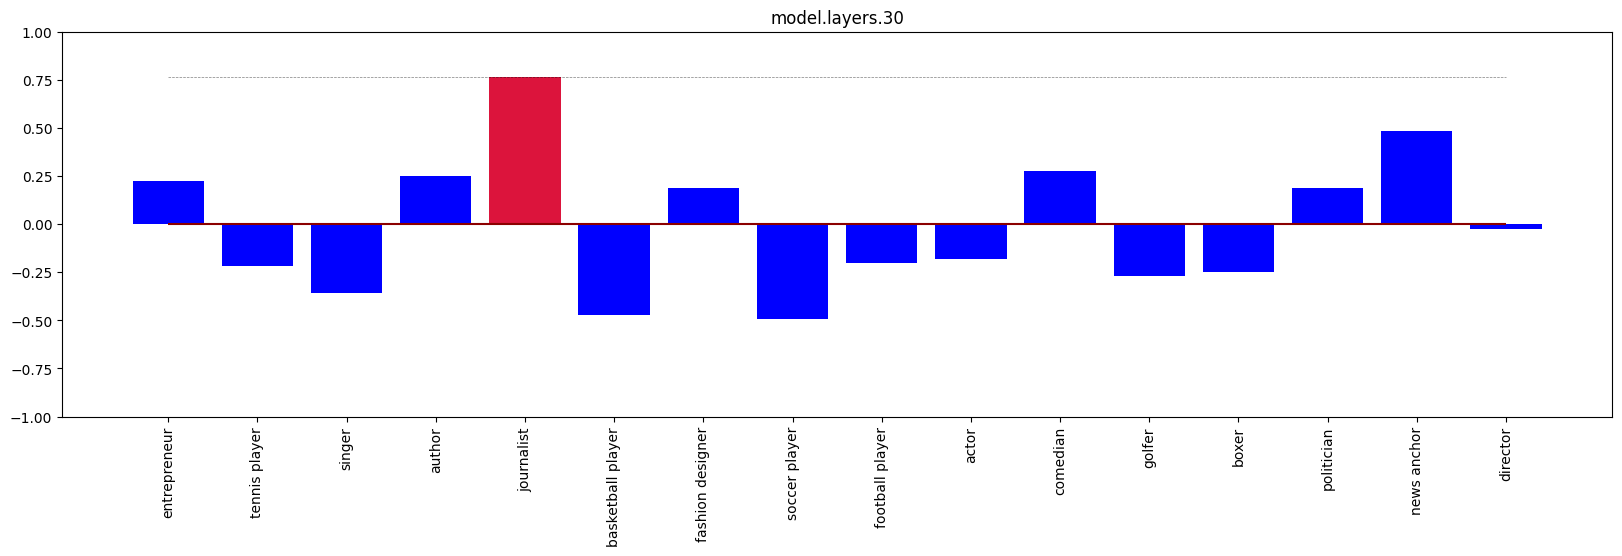

2025-08-04 14:18:57 __main__ INFO     model.layers.30 = [('journalist', 0.765625), ('news anchor', 0.482421875), ('comedian', 0.275390625), ('author', 0.248046875), ('entrepreneur', 0.224609375), ('politician', 0.189453125), ('fashion designer', 0.185546875), ('director', -0.0272216796875), ('actor', -0.1796875), ('football player', -0.2001953125), ('tennis player', -0.2197265625), ('boxer', -0.248046875), ('golfer', -0.271484375), ('singer', -0.357421875), ('basketball player', -0.47265625), ('soccer player', -0.4921875)]


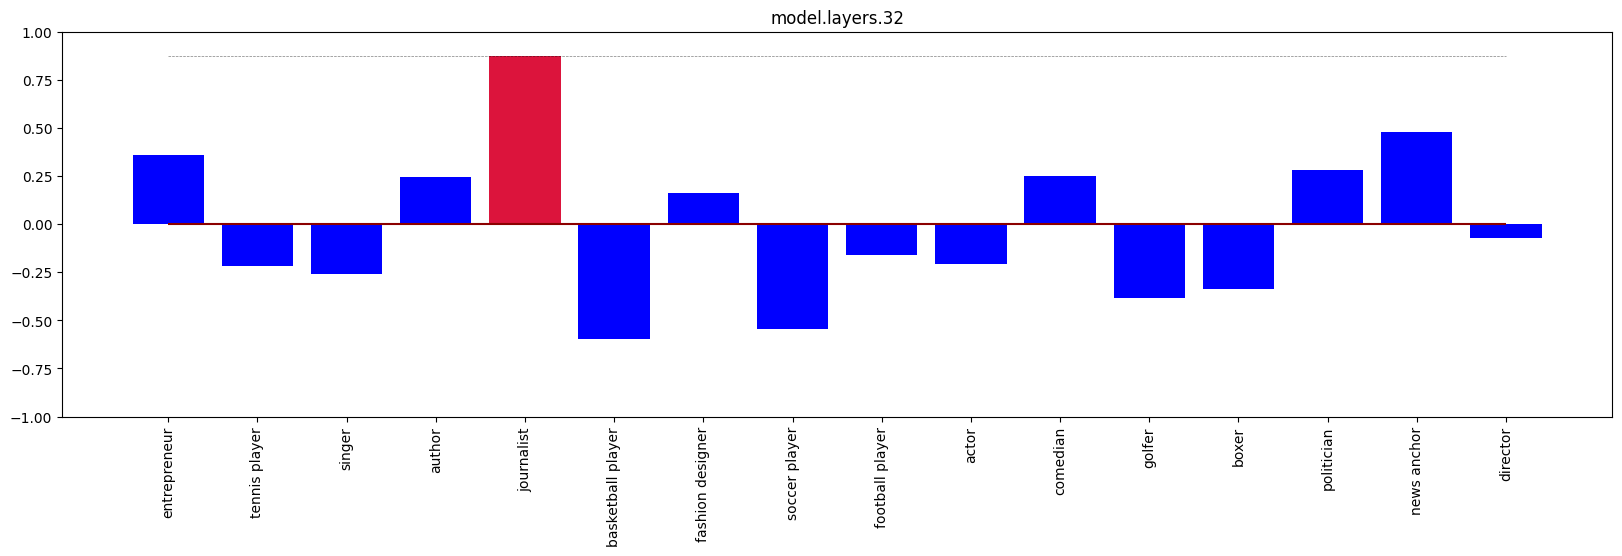

2025-08-04 14:18:57 __main__ INFO     model.layers.32 = [('journalist', 0.87109375), ('news anchor', 0.4765625), ('entrepreneur', 0.359375), ('politician', 0.28125), ('comedian', 0.2490234375), ('author', 0.2421875), ('fashion designer', 0.16015625), ('director', -0.07421875), ('football player', -0.1630859375), ('actor', -0.205078125), ('tennis player', -0.2197265625), ('singer', -0.2578125), ('boxer', -0.3359375), ('golfer', -0.38671875), ('soccer player', -0.54296875), ('basketball player', -0.59765625)]


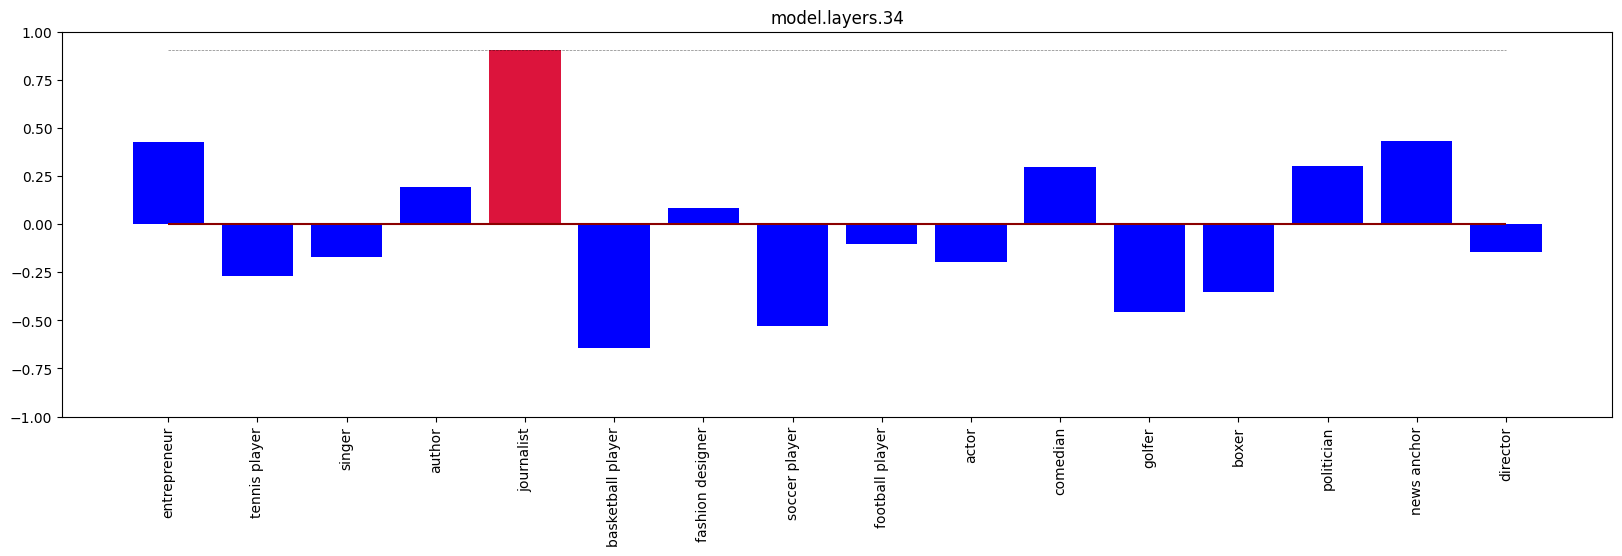

2025-08-04 14:18:57 __main__ INFO     model.layers.34 = [('journalist', 0.90625), ('news anchor', 0.431640625), ('entrepreneur', 0.423828125), ('politician', 0.302734375), ('comedian', 0.298828125), ('author', 0.1943359375), ('fashion designer', 0.08203125), ('football player', -0.10595703125), ('director', -0.1435546875), ('singer', -0.171875), ('actor', -0.1962890625), ('tennis player', -0.271484375), ('boxer', -0.35546875), ('golfer', -0.458984375), ('soccer player', -0.52734375), ('basketball player', -0.64453125)]


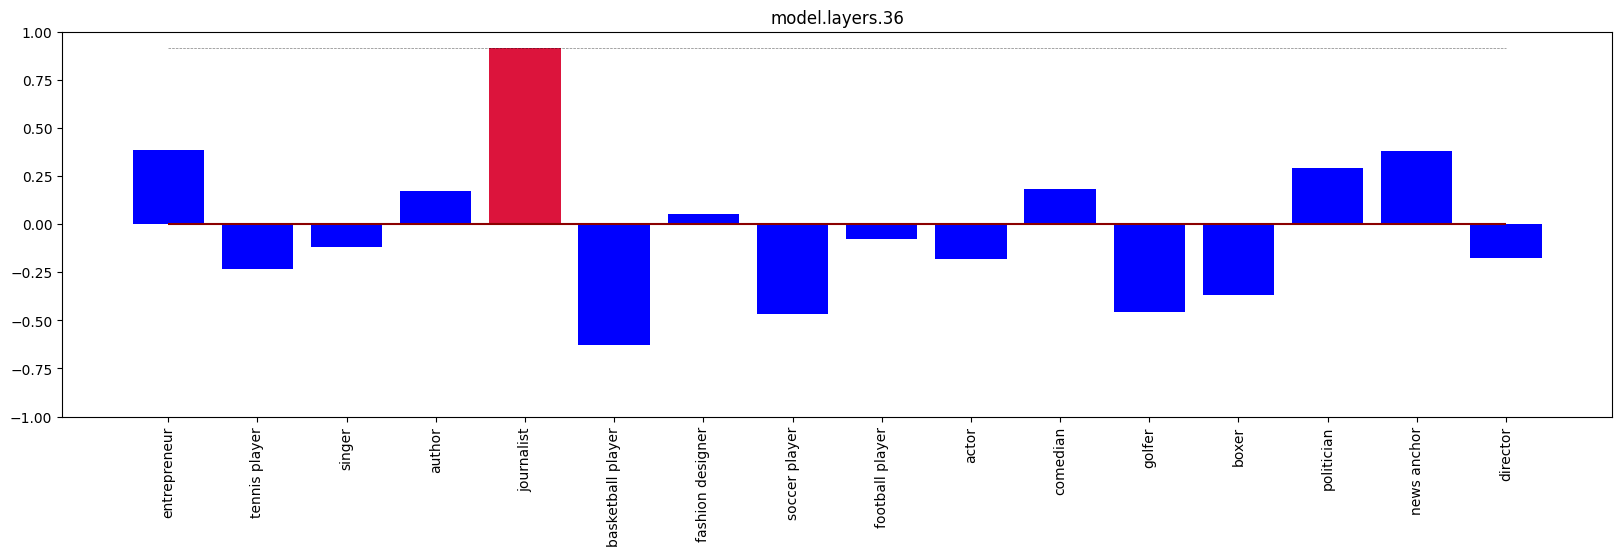

2025-08-04 14:18:57 __main__ INFO     model.layers.36 = [('journalist', 0.9140625), ('entrepreneur', 0.384765625), ('news anchor', 0.37890625), ('politician', 0.2890625), ('comedian', 0.181640625), ('author', 0.171875), ('fashion designer', 0.053955078125), ('football player', -0.076171875), ('singer', -0.11962890625), ('director', -0.1787109375), ('actor', -0.1826171875), ('tennis player', -0.2353515625), ('boxer', -0.369140625), ('golfer', -0.455078125), ('soccer player', -0.46875), ('basketball player', -0.62890625)]


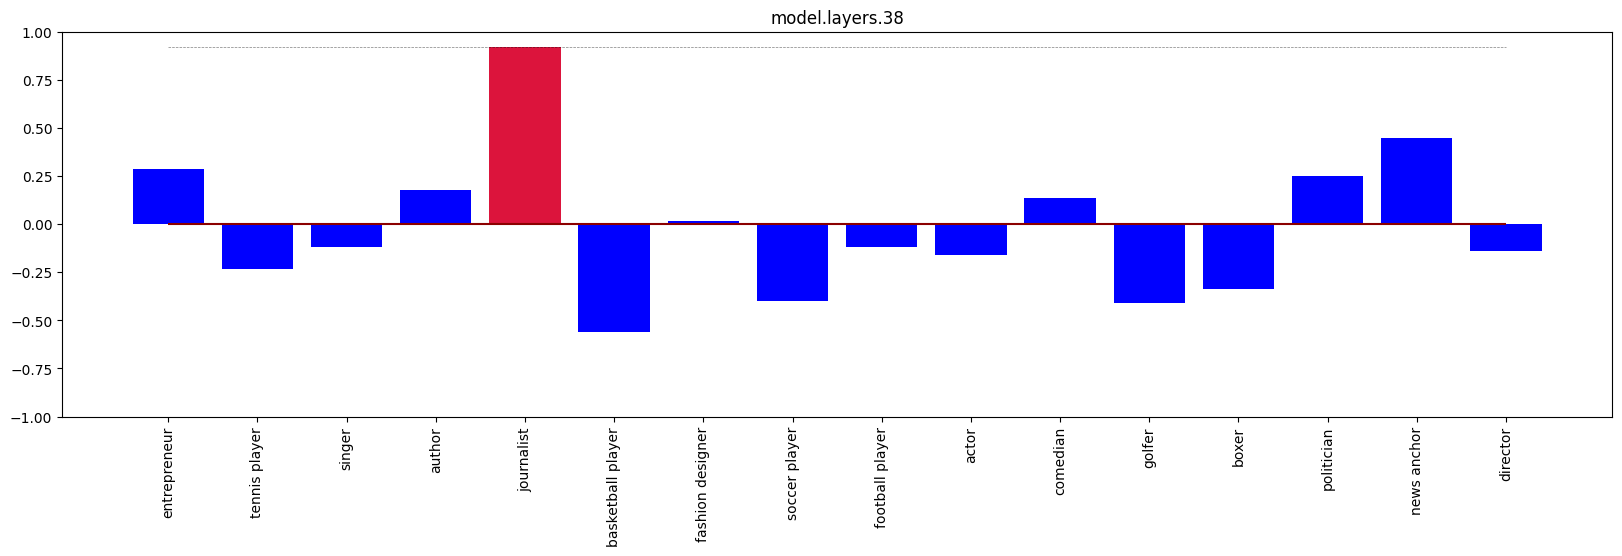

2025-08-04 14:18:57 __main__ INFO     model.layers.38 = [('journalist', 0.91796875), ('news anchor', 0.447265625), ('entrepreneur', 0.287109375), ('politician', 0.25), ('author', 0.1787109375), ('comedian', 0.1337890625), ('fashion designer', 0.01416015625), ('singer', -0.12158203125), ('football player', -0.12158203125), ('director', -0.1416015625), ('actor', -0.1630859375), ('tennis player', -0.2333984375), ('boxer', -0.3359375), ('soccer player', -0.400390625), ('golfer', -0.408203125), ('basketball player', -0.55859375)]


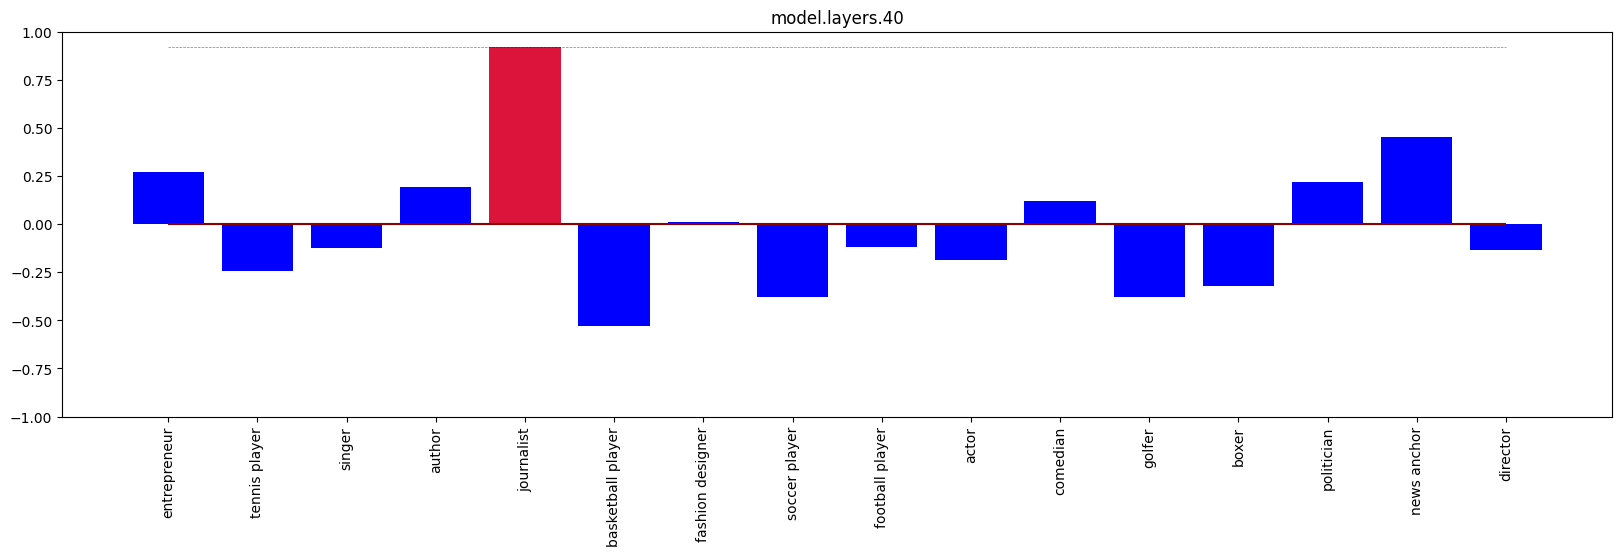

2025-08-04 14:18:58 __main__ INFO     model.layers.40 = [('journalist', 0.921875), ('news anchor', 0.453125), ('entrepreneur', 0.26953125), ('politician', 0.216796875), ('author', 0.1904296875), ('comedian', 0.11962890625), ('fashion designer', 0.0111083984375), ('football player', -0.1201171875), ('singer', -0.1240234375), ('director', -0.1357421875), ('actor', -0.1865234375), ('tennis player', -0.2451171875), ('boxer', -0.3203125), ('soccer player', -0.376953125), ('golfer', -0.380859375), ('basketball player', -0.52734375)]


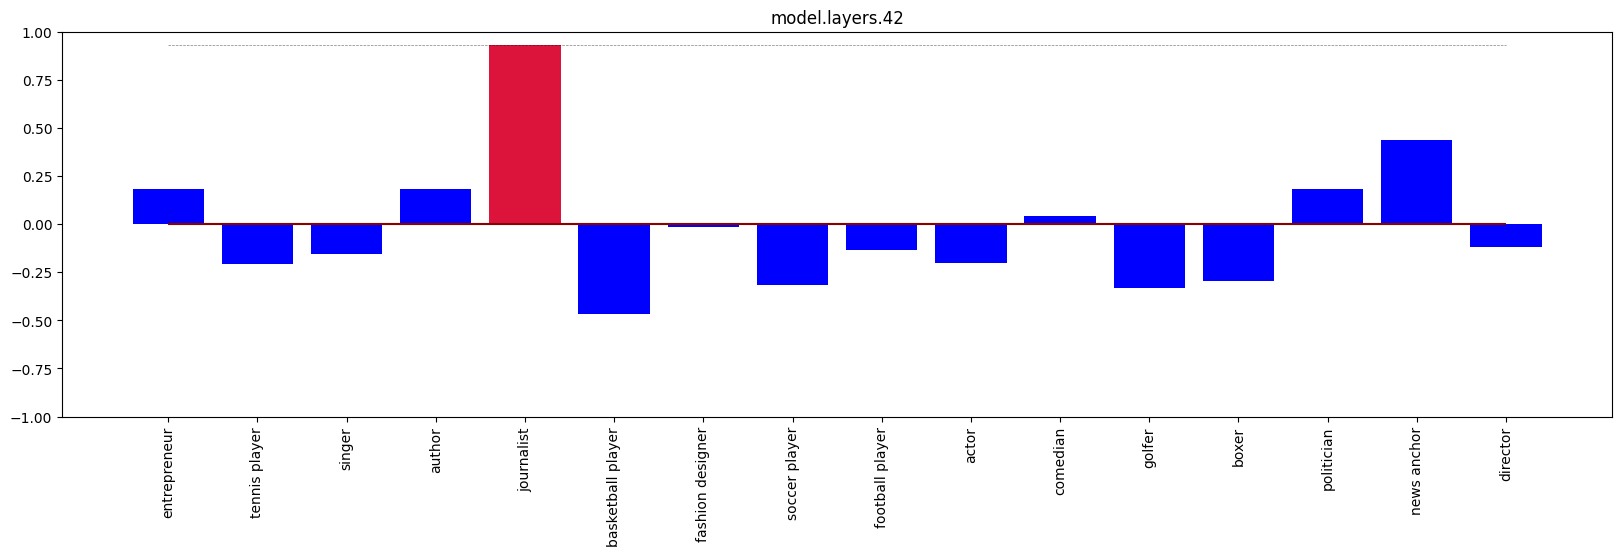

2025-08-04 14:18:58 __main__ INFO     model.layers.42 = [('journalist', 0.9296875), ('news anchor', 0.4375), ('entrepreneur', 0.18359375), ('author', 0.18359375), ('politician', 0.1796875), ('comedian', 0.041748046875), ('fashion designer', -0.01361083984375), ('director', -0.12158203125), ('football player', -0.13671875), ('singer', -0.154296875), ('actor', -0.2021484375), ('tennis player', -0.2080078125), ('boxer', -0.296875), ('soccer player', -0.318359375), ('golfer', -0.33203125), ('basketball player', -0.466796875)]


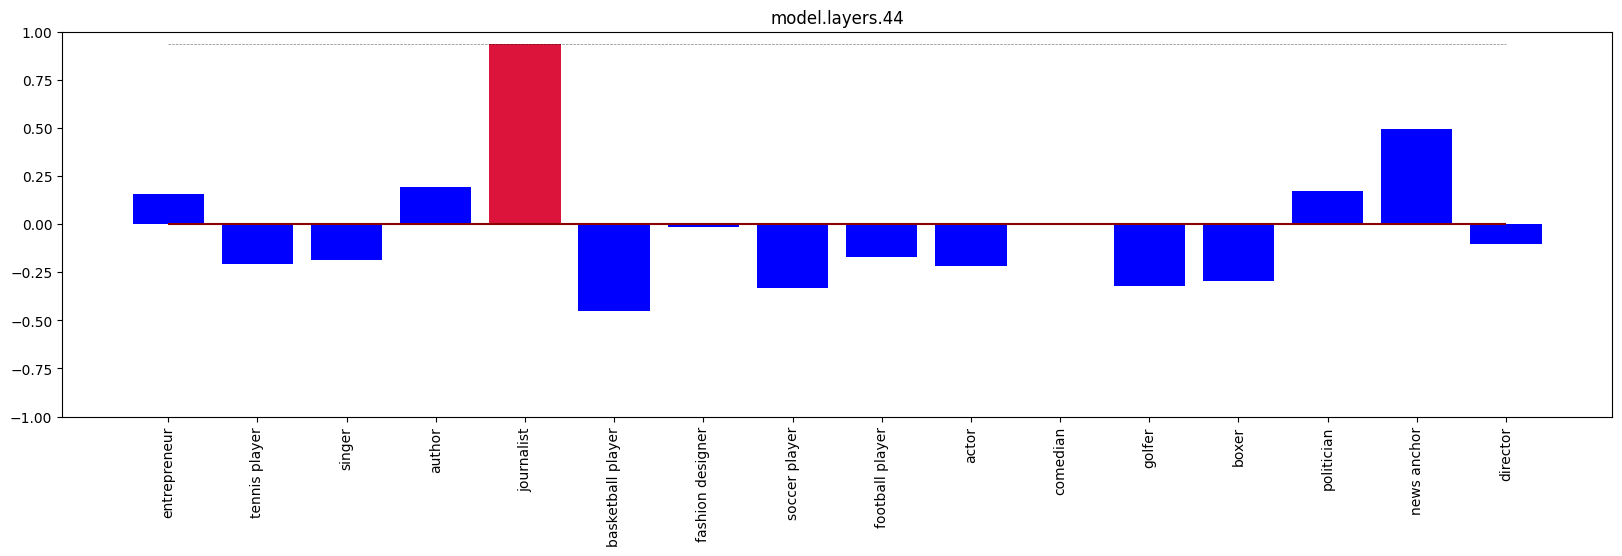

2025-08-04 14:18:58 __main__ INFO     model.layers.44 = [('journalist', 0.9375), ('news anchor', 0.494140625), ('author', 0.193359375), ('politician', 0.169921875), ('entrepreneur', 0.158203125), ('comedian', 0.005401611328125), ('fashion designer', -0.0157470703125), ('director', -0.1044921875), ('football player', -0.169921875), ('singer', -0.189453125), ('tennis player', -0.20703125), ('actor', -0.2197265625), ('boxer', -0.296875), ('golfer', -0.3203125), ('soccer player', -0.330078125), ('basketball player', -0.44921875)]


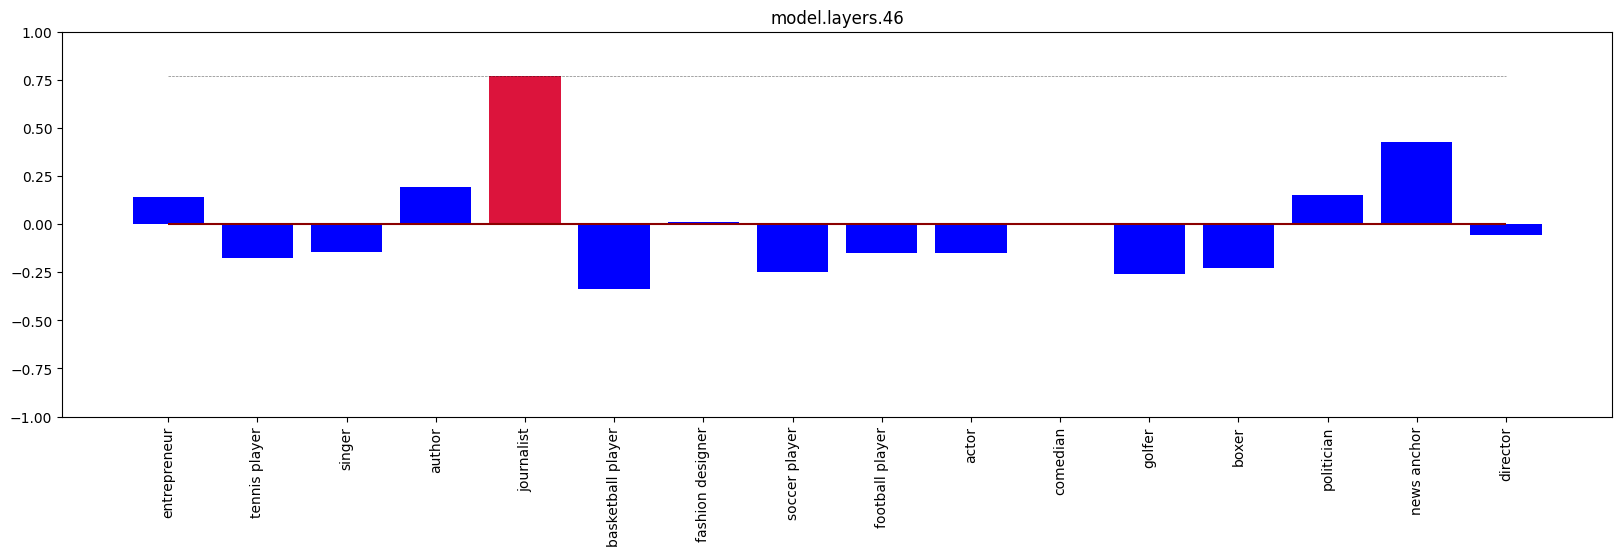

2025-08-04 14:18:58 __main__ INFO     model.layers.46 = [('journalist', 0.76953125), ('news anchor', 0.42578125), ('author', 0.19140625), ('politician', 0.1494140625), ('entrepreneur', 0.140625), ('fashion designer', 0.0113525390625), ('comedian', -0.00015926361083984375), ('director', -0.05908203125), ('singer', -0.1474609375), ('actor', -0.1484375), ('football player', -0.1513671875), ('tennis player', -0.1748046875), ('boxer', -0.2275390625), ('soccer player', -0.248046875), ('golfer', -0.259765625), ('basketball player', -0.33984375)]


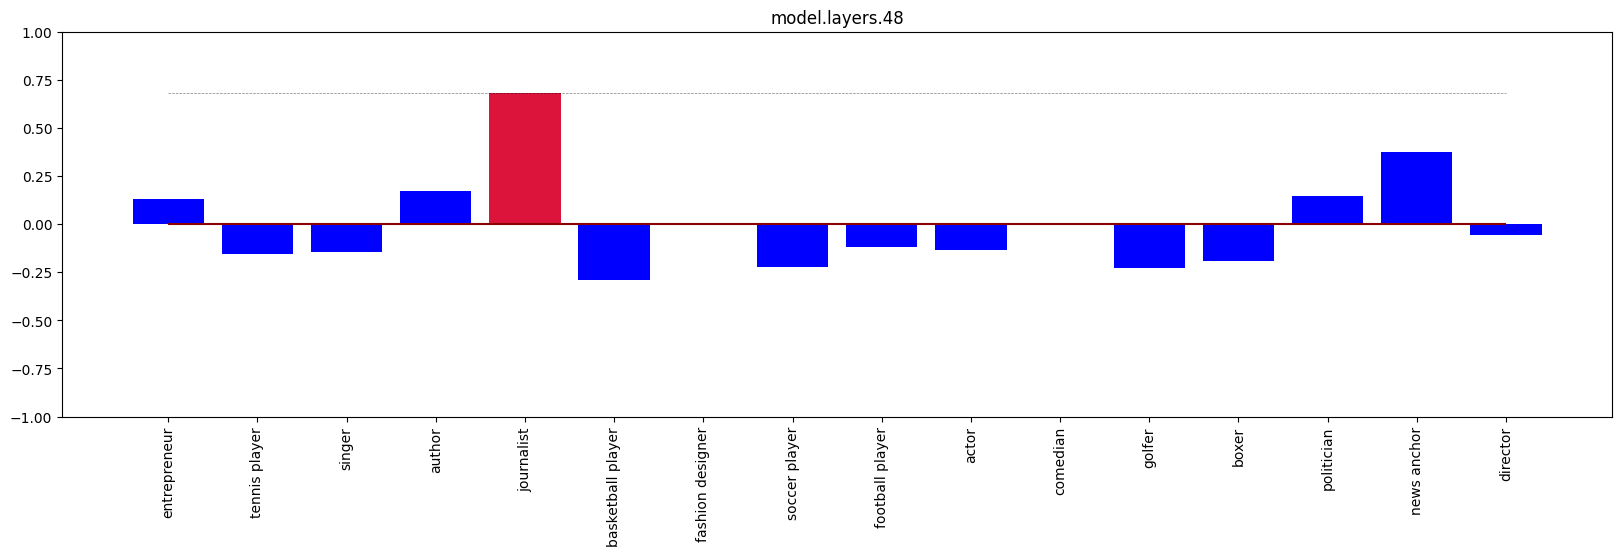

2025-08-04 14:18:58 __main__ INFO     model.layers.48 = [('journalist', 0.6796875), ('news anchor', 0.375), ('author', 0.171875), ('politician', 0.1435546875), ('entrepreneur', 0.1279296875), ('comedian', -0.00010251998901367188), ('fashion designer', -0.0069580078125), ('director', -0.058349609375), ('football player', -0.11767578125), ('actor', -0.13671875), ('singer', -0.146484375), ('tennis player', -0.1572265625), ('boxer', -0.1943359375), ('soccer player', -0.220703125), ('golfer', -0.2275390625), ('basketball player', -0.29296875)]


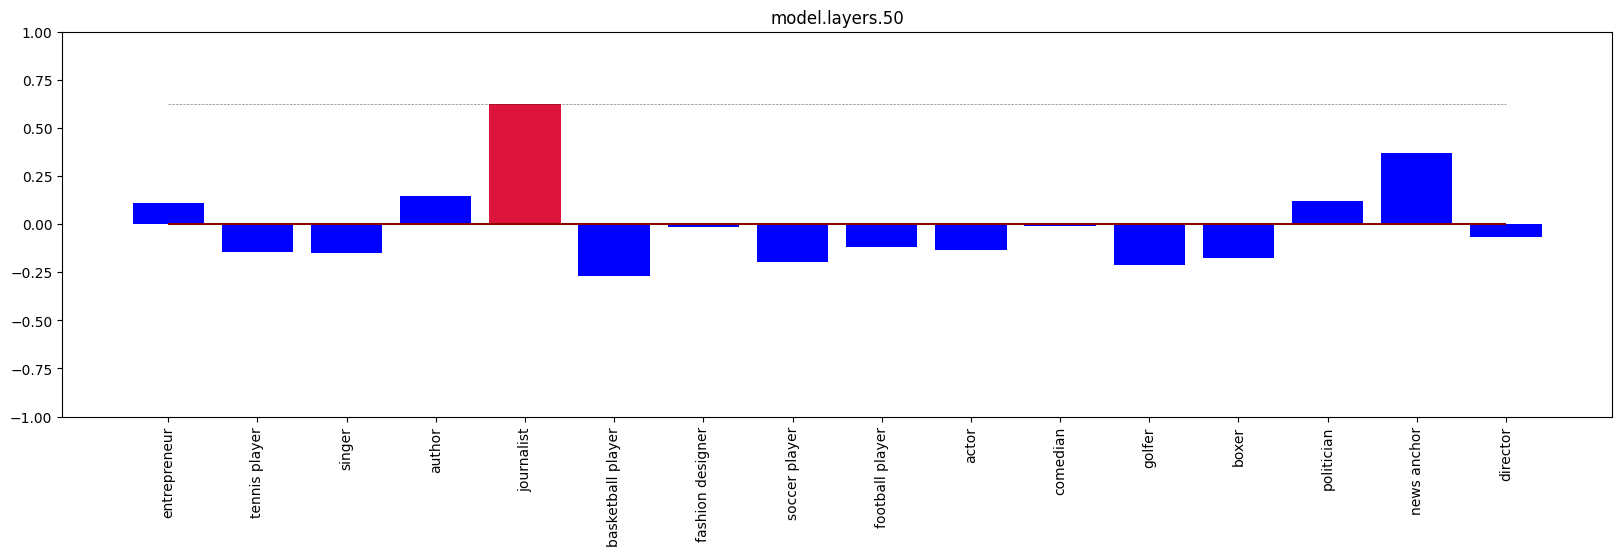

2025-08-04 14:18:58 __main__ INFO     model.layers.50 = [('journalist', 0.62109375), ('news anchor', 0.37109375), ('author', 0.1455078125), ('politician', 0.11767578125), ('entrepreneur', 0.10693359375), ('comedian', -0.01055908203125), ('fashion designer', -0.0147705078125), ('director', -0.0654296875), ('football player', -0.1201171875), ('actor', -0.13671875), ('tennis player', -0.14453125), ('singer', -0.150390625), ('boxer', -0.17578125), ('soccer player', -0.1962890625), ('golfer', -0.2138671875), ('basketball player', -0.271484375)]


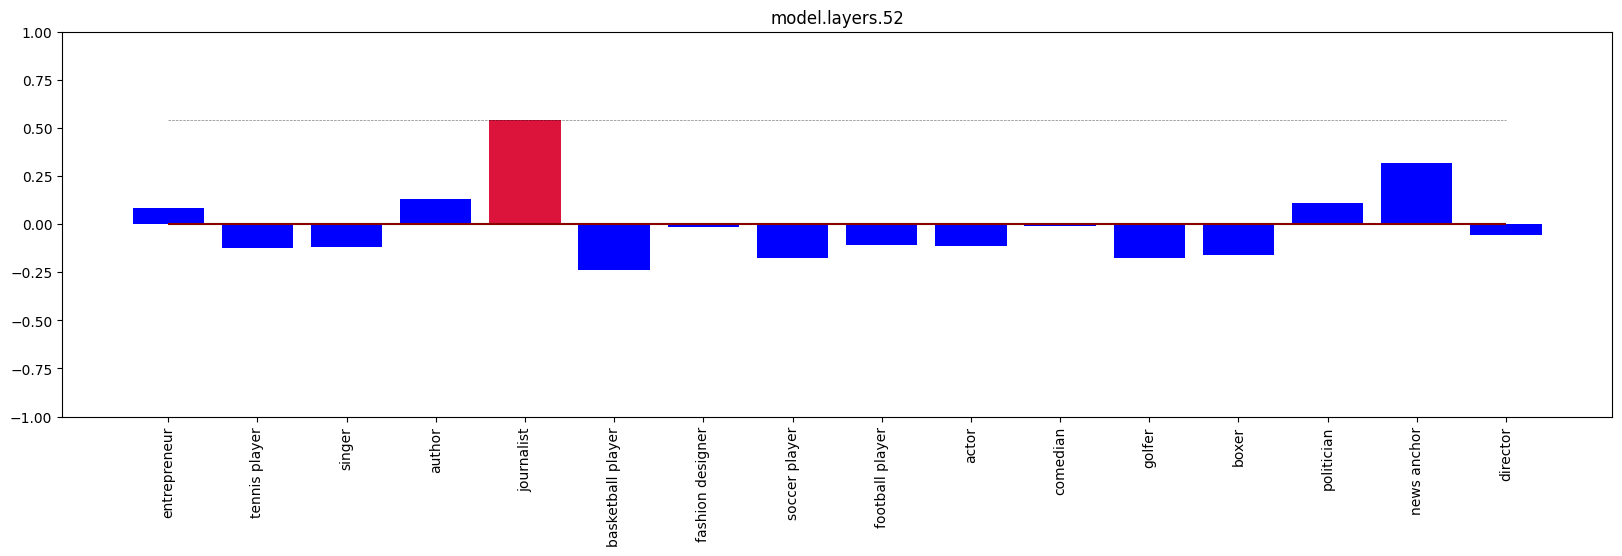

2025-08-04 14:18:59 __main__ INFO     model.layers.52 = [('journalist', 0.5390625), ('news anchor', 0.318359375), ('author', 0.1318359375), ('politician', 0.107421875), ('entrepreneur', 0.0810546875), ('comedian', -0.0086669921875), ('fashion designer', -0.016845703125), ('director', -0.054443359375), ('football player', -0.11083984375), ('actor', -0.1162109375), ('singer', -0.119140625), ('tennis player', -0.126953125), ('boxer', -0.16015625), ('soccer player', -0.1767578125), ('golfer', -0.1787109375), ('basketball player', -0.236328125)]


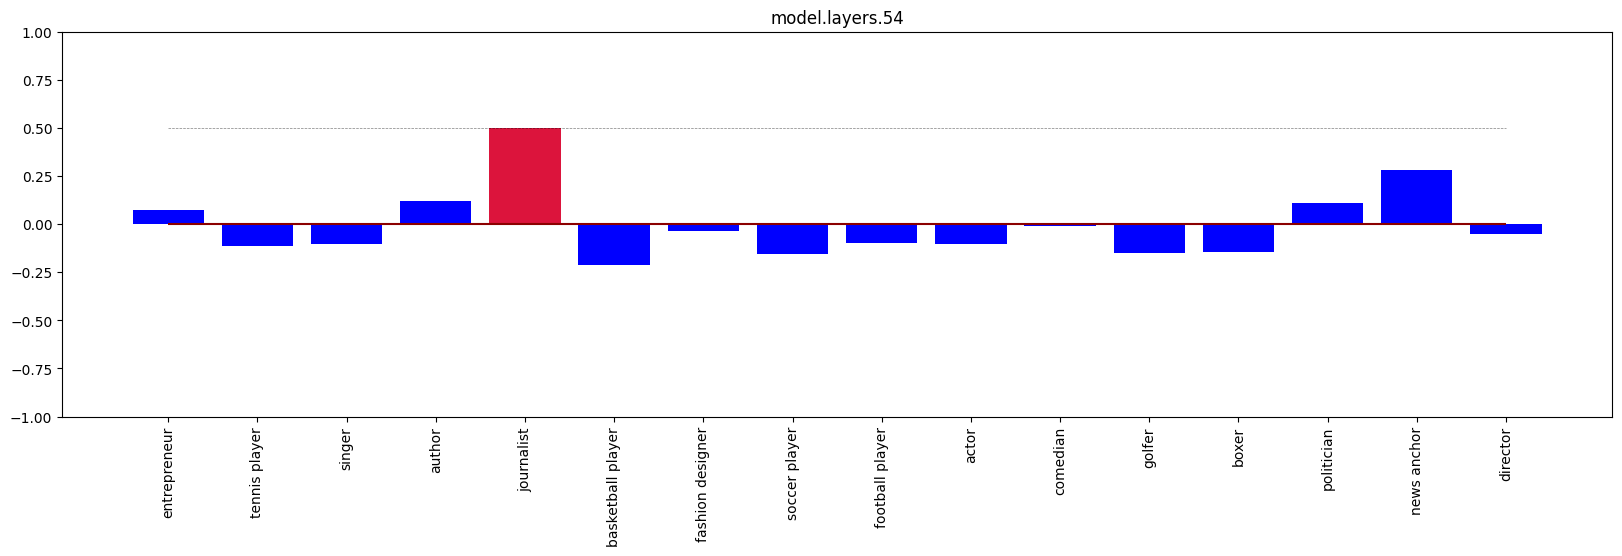

2025-08-04 14:18:59 __main__ INFO     model.layers.54 = [('journalist', 0.498046875), ('news anchor', 0.283203125), ('author', 0.1201171875), ('politician', 0.10888671875), ('entrepreneur', 0.07275390625), ('comedian', -0.0103759765625), ('fashion designer', -0.03466796875), ('director', -0.05322265625), ('football player', -0.09912109375), ('singer', -0.10205078125), ('actor', -0.10498046875), ('tennis player', -0.1123046875), ('boxer', -0.1435546875), ('golfer', -0.1494140625), ('soccer player', -0.158203125), ('basketball player', -0.2119140625)]
Layer 33, Head 45
Layer 33, Head 18
Layer 34, Head 1
Layer 34, Head 6
Layer 34, Head 7
Layer 35, Head 19
Layer 39, Head 40
Layer 42, Head 30
Layer 47, Head 18
Layer 52, Head 58


[PredictedToken(token=' None', prob=0.357421875, logit=16.375, token_id=2290, metadata=None),
 PredictedToken(token=' The', prob=0.11572265625, logit=15.25, token_id=578, metadata=None),
 PredictedToken(token=' Maggie', prob=0.07470703125, logit=14.8125, token_id=62795, metadata=None),
 PredictedToken(token=' Dmitry', prob=0.04833984375, logit=14.375, token_id=88231, metadata=None),
 PredictedToken(token=' none', prob=0.04541015625, logit=14.3125, token_id=7000, metadata=None)]

In [249]:
from src.functional import PatchSpec
from src.tokens import prepare_input
from src.attention import get_attention_matrices, visualize_attn_matrix, visualize_average_attn_matrix
from src.functional import interpret_logits

promote_concept = sample.metadata["attribute"]
promote_directions = probe_directions[promote_concept]
beta = 5

tokenized = prepare_input(
    prompts=prompt,
    tokenizer=mt,
)

clean_hs = get_hs(
    mt=mt,
    input=tokenized,
    locations=[
        (mt.layer_name_format.format(layer_idx), -1) for layer_idx in range(mt.n_layer)
    ],
    return_dict=True,
)
patch_hs = []

for layer_idx in range(25, 45):
    layer_name = mt.layer_name_format.format(layer_idx)
    promote_dir = promote_directions[layer_name].to(mt.dtype).to(mt.device)
    # suppress_dir = suppress_directions[layer_name].to(mt.dtype).to(mt.device)

    orig_h = clean_hs[(layer_name, -1)].to(mt.dtype).to(mt.device)

    # ! Uncommenting this will have the desired effect
    # h_suppress = (
    #     torch.dot(orig_h, suppress_dir) / suppress_dir.norm() ** 2 * suppress_dir
    # )
    h_promote = torch.dot(orig_h, promote_dir) / promote_dir.norm() ** 2 * promote_dir
    patch_h = orig_h + beta * h_promote # - beta * h_suppress

    patch_hs.append(
        PatchSpec(location=(layer_name, -1), patch=patch_h.to(mt.dtype).to(mt.device))
    )

hs = get_hs(mt=mt, input=prompt, locations=locations, return_dict=True, patches=patch_hs)
hs = {layer_name: latent for (layer_name, token_idx), latent in hs.items()}

layerwise_scores = mean_probes.apply_all_layers(
    hs=hs,
    layer_names=hs.keys(),
)

MeanProbes.bar_chart_per_layer(
    scores={
        layer_name: layerwise_scores[layer_name]
        for layer_name in [
            mt.layer_name_format.format(layer_idx) for layer_idx in range(30, 55, 2)
        ]
    },
    highlight_categories=[sample.metadata["attribute"]],
)

steered_attn_matrices = get_attention_matrices(
    input=tokenized, mt=mt, value_weighted=False, 
    patches=patch_hs
)

HEADS = [
    (33, 45),
    (33, 18),
    (34, 1),
    (34, 6),
    (34, 7),
    (35, 19),
    (39, 40),
    (42, 30),
    (47, 18),
    (52, 58),
]


selection_head_matrices = []

for layer_idx, head_idx in HEADS:
    print(f"Layer {layer_idx}, Head {head_idx}")
    attn_matrix = (
        torch.Tensor(
            steered_attn_matrices.attention_matrices[layer_idx, head_idx]
        )
        .squeeze()
    )
    selection_head_matrices.append(attn_matrix)

    # print(attn_matrix.shape, tokenized.input_ids.shape)

    # visualize_attn_matrix(
    #     attn_matrix=attn_matrix,
    #     tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    #     q_index=-1,
    #     start_from=1,
    # )
    
    # print("=" * 150)

visualize_attn_matrix(
    attn_matrix=torch.stack(selection_head_matrices, dim=0).mean(dim=0),
    tokens=[mt.tokenizer.decode(t) for t in tokenized.input_ids[0]],
    q_index=-1,
    start_from=1,
)

interpret_logits(tokenizer=mt, logits=steered_attn_matrices.logits)

In [248]:
[str(p) for p in interpret_logits(tokenizer=mt, logits=steered_attn_matrices.logits)]

['" None"[2290] (p=0.357, logit=16.375)',
 '" The"[578] (p=0.116, logit=15.250)',
 '" Maggie"[62795] (p=0.075, logit=14.812)',
 '" Dmitry"[88231] (p=0.048, logit=14.375)',
 '" none"[7000] (p=0.045, logit=14.312)']